In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [3]:
# From model/collectdata.py
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
# from model.kde_loss_B import Loss


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model

from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [4]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [5]:
##device = select_gpu(0)
device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
batch_size = 16
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                                batch_size=batch_size,
                                device=device,
                                slice = slice(0,20))

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

# Preparing the models

Prepare the trained models, use multiple GPUs if they are VISIBLE, and move the models to the device.

In [7]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
models = {}
models_dict = {}

for i in range(50):
    models[i] = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
    models_dict[i] = models[i].state_dict()
#model_latest = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
#model_old = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

In [42]:
folders = {}
for i in range(50):
    folders[i] = ''
    
folders[1]  = '22December_testing_DDplus_loss_Bb_iter1_floatAll_100epochs_1em5'
#folders[4]  = '25December__DDplus_loss_Ba_iter4_floatAll_500epochs_1em5'
folders[7]  = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
folders[27] = '05Feb_DDplus_loss_Ba_iter27_floatAll_100epochs_1p5em5_4xwill'
folders[28] = '06Feb_DDplus_loss_Ba_iter28_floatAll_100epochs_1p5em5_4xwill'
folders[29] = '07Feb_DDplus_loss_Ba_iter29_floatAll_100epochs_1p5em5_4xwill'
iters = [1,7,27,28,29]

mycolors = {1:'green',7:'darkorange',27:'red',28:'magenta',29:'gold'}

'''
##folder = '20December_testing_DDplus_first_learning_10epochs_1em4'
## folder = '20December_testing_DDplus_iter1_20epochs_1em4'
##folder = '20December_testing_DDplus_iter2_floatAll_50epochs_1em4'
##folder = '20December_testing_DDplus_iter4_floatAll_200epochs_6em5'
##folder = '20December_testing_DDplus_loss_Ba_iter1_floatAll_100epochs_1em3'
##folder = '20December_testing_DDplus_loss_Ba_iter2_floatAll_700epochs_2em4'
folder = '21December_testing_DDplus_loss_Ba_iter4_floatAll_700epochs_5em6'
##folder = '20December_testing_DDplus_loss_Ba_iter2_floatAll_700epochs_5em5'
folder = '22December_testing_DDplus_loss_Bb_iter0_floatAll_20epochs_1em4'
folder = '22December_testing_DDplus_loss_Bb_iter1_floatAll_100epochs_1em5'
folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'  ## final training cost 1.31031
##folder = '22December_testing_DDplus_loss_Bb_realBb_iter0A_floatAll_50epochs_1em5'
##folder = '22December_testing_DDplus_loss_Bb_realBb_iter2A_floatAll_100epochs_2em6'
##folder = '22December_testing_DDplus_loss_Bb__iter0c_floatAll_fromScratch_20epochs_1em3'
folder = '25December__DDplus_loss_Ba_iter4_floatAll_500epochs_1em5'
folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_1em5'
folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
folder_old = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
folder_latest = '05Feb_DDplus_loss_Ba_iter%s_floatAll_100epochs_1p5em5_4xwill'%(nIter)
'''

"\n##folder = '20December_testing_DDplus_first_learning_10epochs_1em4'\n## folder = '20December_testing_DDplus_iter1_20epochs_1em4'\n##folder = '20December_testing_DDplus_iter2_floatAll_50epochs_1em4'\n##folder = '20December_testing_DDplus_iter4_floatAll_200epochs_6em5'\n##folder = '20December_testing_DDplus_loss_Ba_iter1_floatAll_100epochs_1em3'\n##folder = '20December_testing_DDplus_loss_Ba_iter2_floatAll_700epochs_2em4'\nfolder = '21December_testing_DDplus_loss_Ba_iter4_floatAll_700epochs_5em6'\n##folder = '20December_testing_DDplus_loss_Ba_iter2_floatAll_700epochs_5em5'\nfolder = '22December_testing_DDplus_loss_Bb_iter0_floatAll_20epochs_1em4'\nfolder = '22December_testing_DDplus_loss_Bb_iter1_floatAll_100epochs_1em5'\nfolder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'  ## final training cost 1.31031\n##folder = '22December_testing_DDplus_loss_Bb_realBb_iter0A_floatAll_50epochs_1em5'\n##folder = '22December_testing_DDplus_loss_Bb_realBb_iter2A_floatAll_100ep

In [43]:
suffix = 'final'

weights_dicts = {}
pretrained_dicts = {}
for i in folders.keys():
    if not i in iters:
        continue
    rootDir = 'ML/'
    if i>18:
        rootDir = 'ML_dir/'        
    weights_dicts[i] = rootDir + folders[i] + '/' + folders[i] + '_'+ suffix + '.pyt'
    print(weights_dicts[i])
    pretrained_dicts[i] = torch.load(weights_dicts[i])
    # 1. filter out unnecessary keys
    pretrained_dicts[i] = {k: v for k, v in pretrained_dicts[i].items() if k in models_dict[i]}
    # 2. overwrite entries in the existing state dict
    models_dict[i].update(pretrained_dicts[i]) 
    # 3. load the new state dict
    models[i].load_state_dict(pretrained_dicts[i],strict=False)


ML/22December_testing_DDplus_loss_Bb_iter1_floatAll_100epochs_1em5/22December_testing_DDplus_loss_Bb_iter1_floatAll_100epochs_1em5_final.pyt
ML/25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6/25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6_final.pyt
ML_dir/05Feb_DDplus_loss_Ba_iter27_floatAll_100epochs_1p5em5_4xwill/05Feb_DDplus_loss_Ba_iter27_floatAll_100epochs_1p5em5_4xwill_final.pyt
ML_dir/06Feb_DDplus_loss_Ba_iter28_floatAll_100epochs_1p5em5_4xwill/06Feb_DDplus_loss_Ba_iter28_floatAll_100epochs_1p5em5_4xwill_final.pyt
ML_dir/07Feb_DDplus_loss_Ba_iter29_floatAll_100epochs_1p5em5_4xwill/07Feb_DDplus_loss_Ba_iter29_floatAll_100epochs_1p5em5_4xwill_final.pyt


In [44]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


output_folder = 'ML_dir/Tracks_to_KDE_TestTrainedModel/Model_DDplus_CompIters'
for it in iters:
    output_folder += '_%s'%(it)
output_path = Path(output_folder)
output_path.mkdir(exist_ok=True)


In [45]:
for i in models.keys():
    models[i].to(device)

In [46]:
# dict to store the outputs of the trained models (iteration over same model)
outputs = {}
# dict to store the predicted KDEs from the trained models (iteration over same model)
y_pred = {}

In [47]:
'''
nFeatures = 4000

with torch.no_grad():
    count = 0
    for inputs, labels in val_loader:
        print("count",count)
        if count>0:
            continue
        count+=1
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
        
        # Loop over the trained iterations to retrieve the predictions 
        for it in iters:
            outputs[it] = models[it](inputs)
        
        # Get the number of events from the output of the first trained model 
        nEvts = outputs[iters[0]].shape[0]
        
        # Do something on the true distribution (KDEs) 
        y = labels.view(nEvts,-1,nFeatures)
        y = y.transpose(1,2)               
        
        # LOOP over the events
        for iEvt in range(nEvts):

            # --- Retrieve the TRUE KDEs
            y_kde = y[iEvt,:,0].cpu().numpy()
            # print("y_kde.shape = ",y_kde.shape)

            # --- Retrieve the PREDICTED KDEs for each trained model (iteration over same model)
            for it in iters:
                y_pred[it] = outputs[it][iEvt,:]
                y_pred[it] = y_pred[it].cpu().numpy()
                        
            
            if (iEvt<5):
                fig, ax = plt.subplots()
                plt.ylim(0.0005,1.15*max(y_kde))
                plt.plot(y_kde, color="royalblue", label="True KDE")
                for it in iters:
                    plt.plot(y_pred[it], color=mycolors[it], alpha = 0.8, label="Pred. KDE (iter %s)"%(it))
                plt.legend()
                textstr = '\n'.join((
                r'Evt #%s' % (iEvt, ),     
                ))              
                props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
                ax.text(0.05, 0.95, textstr, transform=ax.transAxes,verticalalignment='top', bbox=props,linespacing = 1.8)#, fontsize=14
                ax.set_xlabel("z (in bin #)")
                ax.set_ylabel("Arbitrary unit")
                plt.show()
'''

'\nnFeatures = 4000\n\nwith torch.no_grad():\n    count = 0\n    for inputs, labels in val_loader:\n        print("count",count)\n        if count>0:\n            continue\n        count+=1\n        if inputs.device != device:\n            inputs, labels = inputs.to(device), labels.to(device)\n        \n        # Loop over the trained iterations to retrieve the predictions \n        for it in iters:\n            outputs[it] = models[it](inputs)\n        \n        # Get the number of events from the output of the first trained model \n        nEvts = outputs[iters[0]].shape[0]\n        \n        # Do something on the true distribution (KDEs) \n        y = labels.view(nEvts,-1,nFeatures)\n        y = y.transpose(1,2)               \n        \n        # LOOP over the events\n        for iEvt in range(nEvts):\n\n            # --- Retrieve the TRUE KDEs\n            y_kde = y[iEvt,:,0].cpu().numpy()\n            # print("y_kde.shape = ",y_kde.shape)\n\n            # --- Retrieve the PREDICT

val_loader =  <torch.utils.data.dataloader.DataLoader object at 0x7f4705be6f10>
nEvts =  20
iEvt =  0


<IPython.core.display.Javascript object>


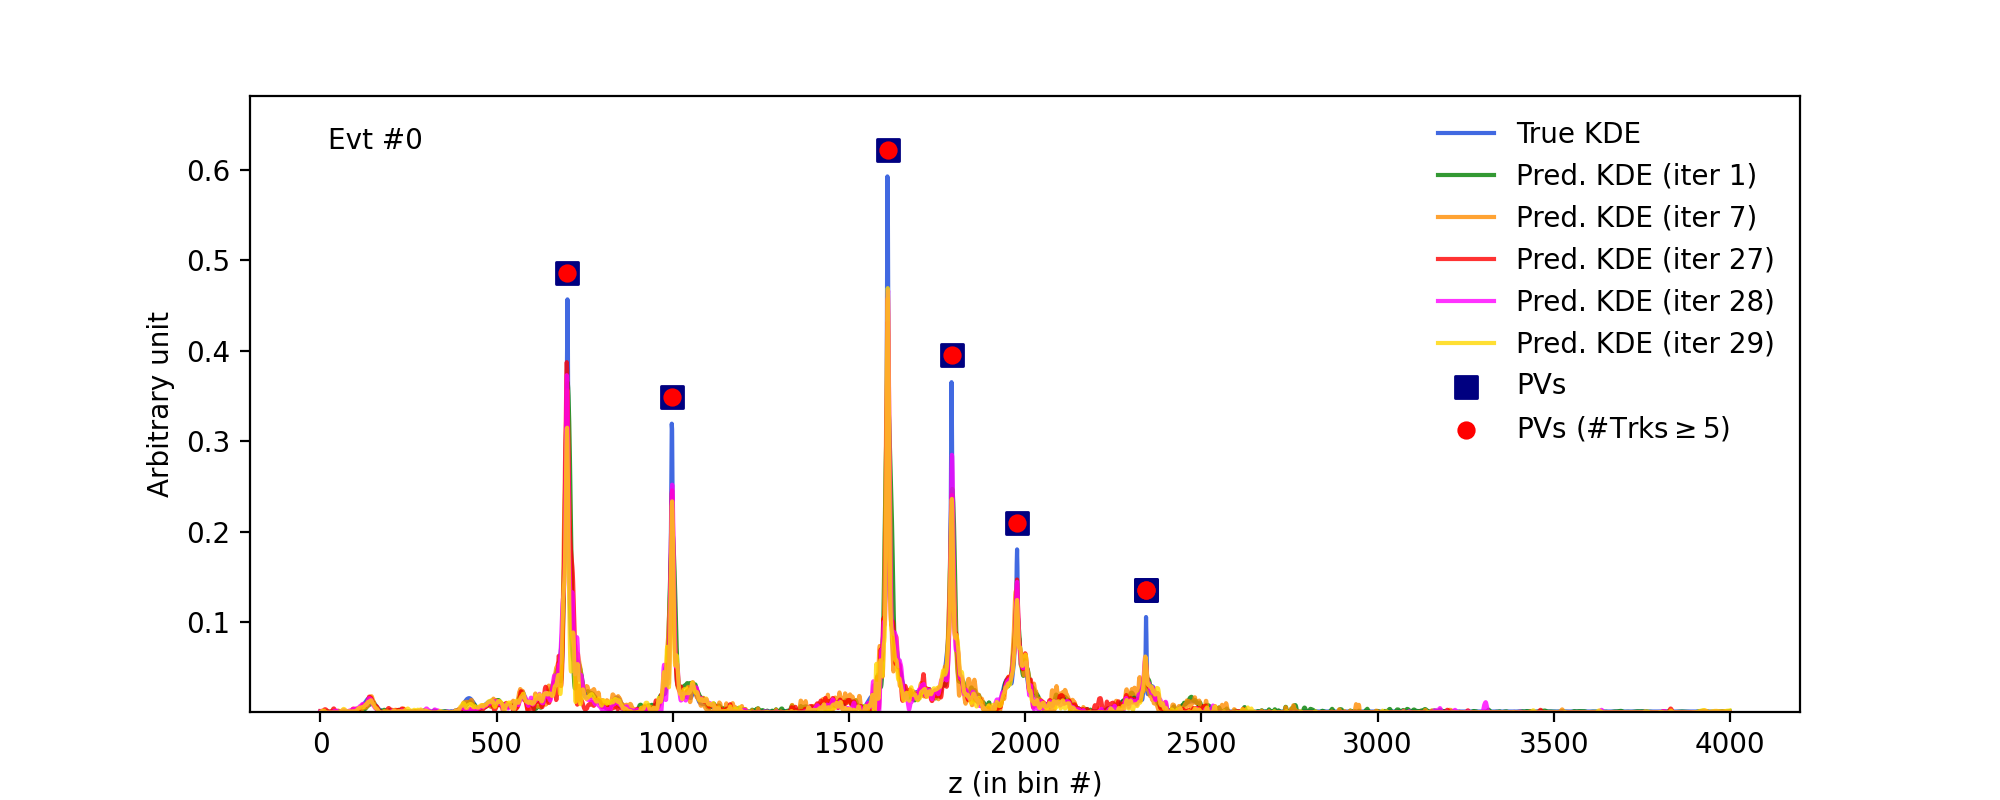

PV position and bin # =  (-29.881668, 1, 24) 701.0


<IPython.core.display.Javascript object>


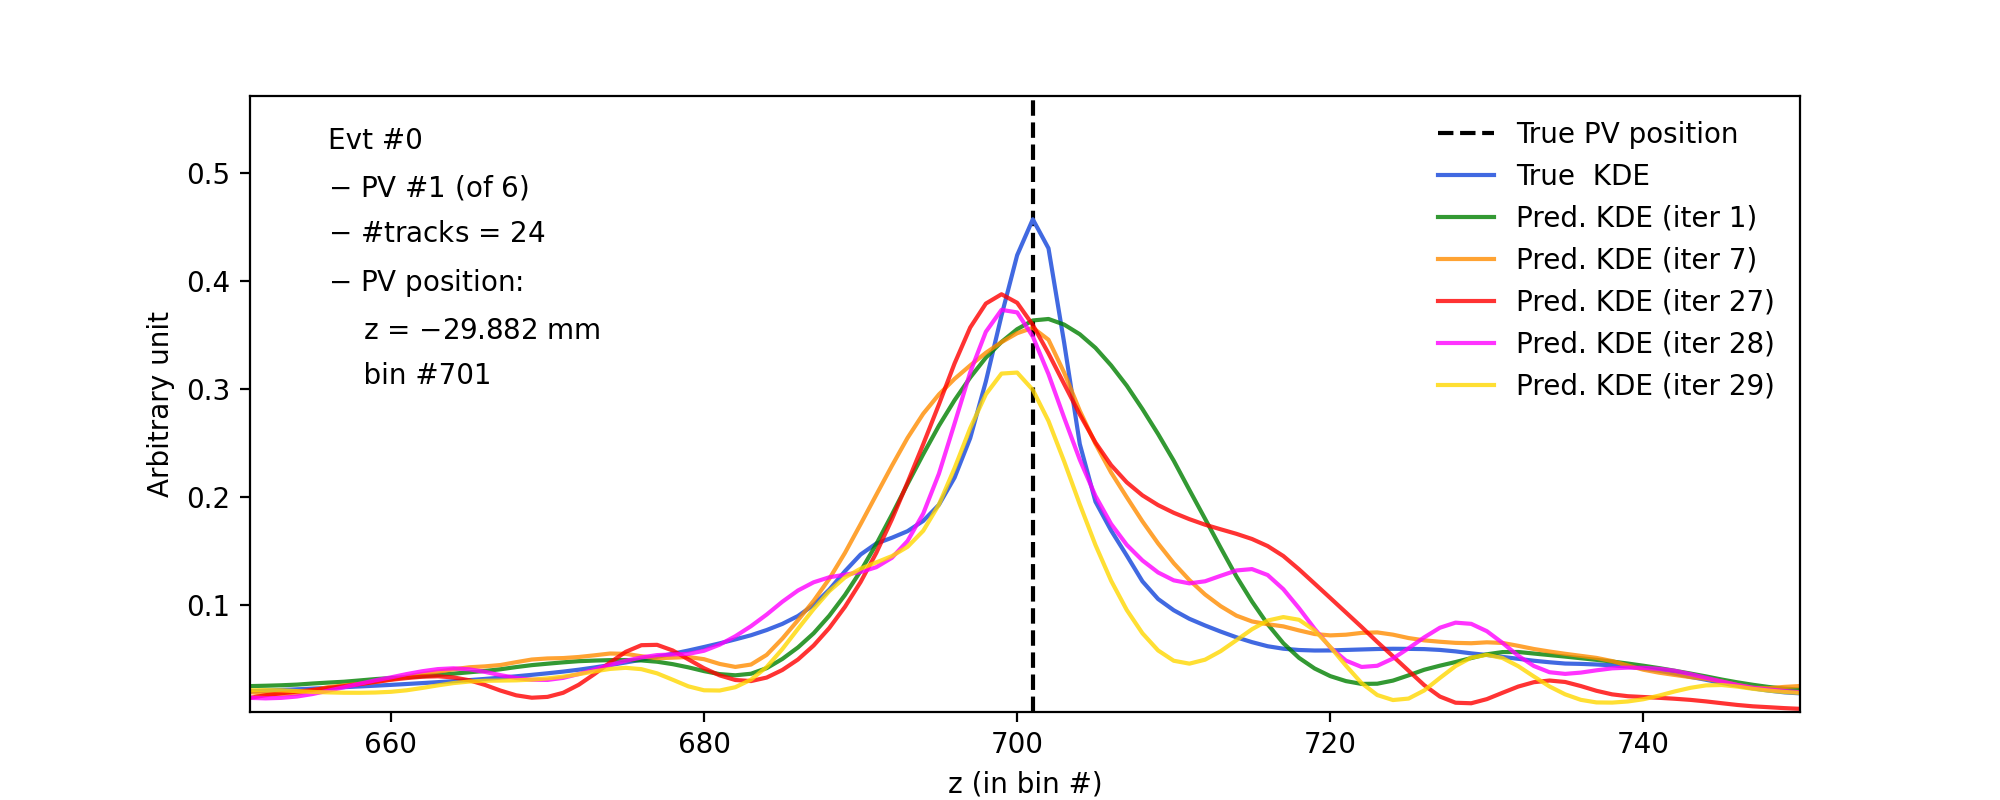

PV position and bin # =  (-0.15807877, 1, 10) 998.0


<IPython.core.display.Javascript object>


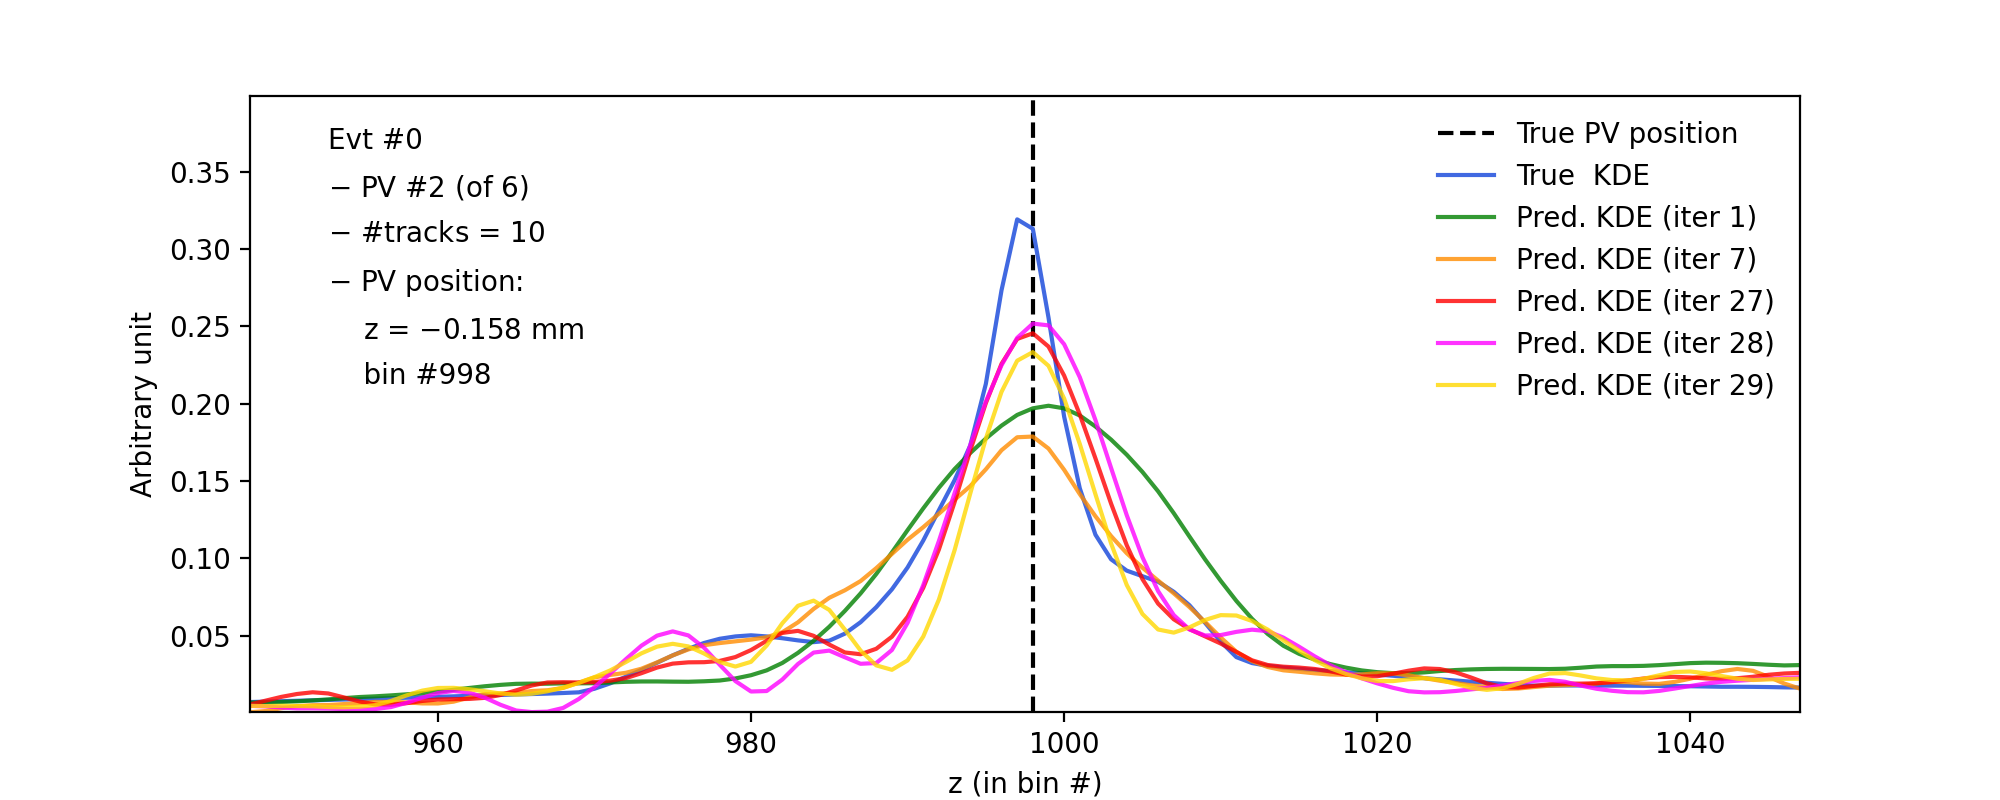

PV position and bin # =  (61.021088, 1, 26) 1610.0


<IPython.core.display.Javascript object>


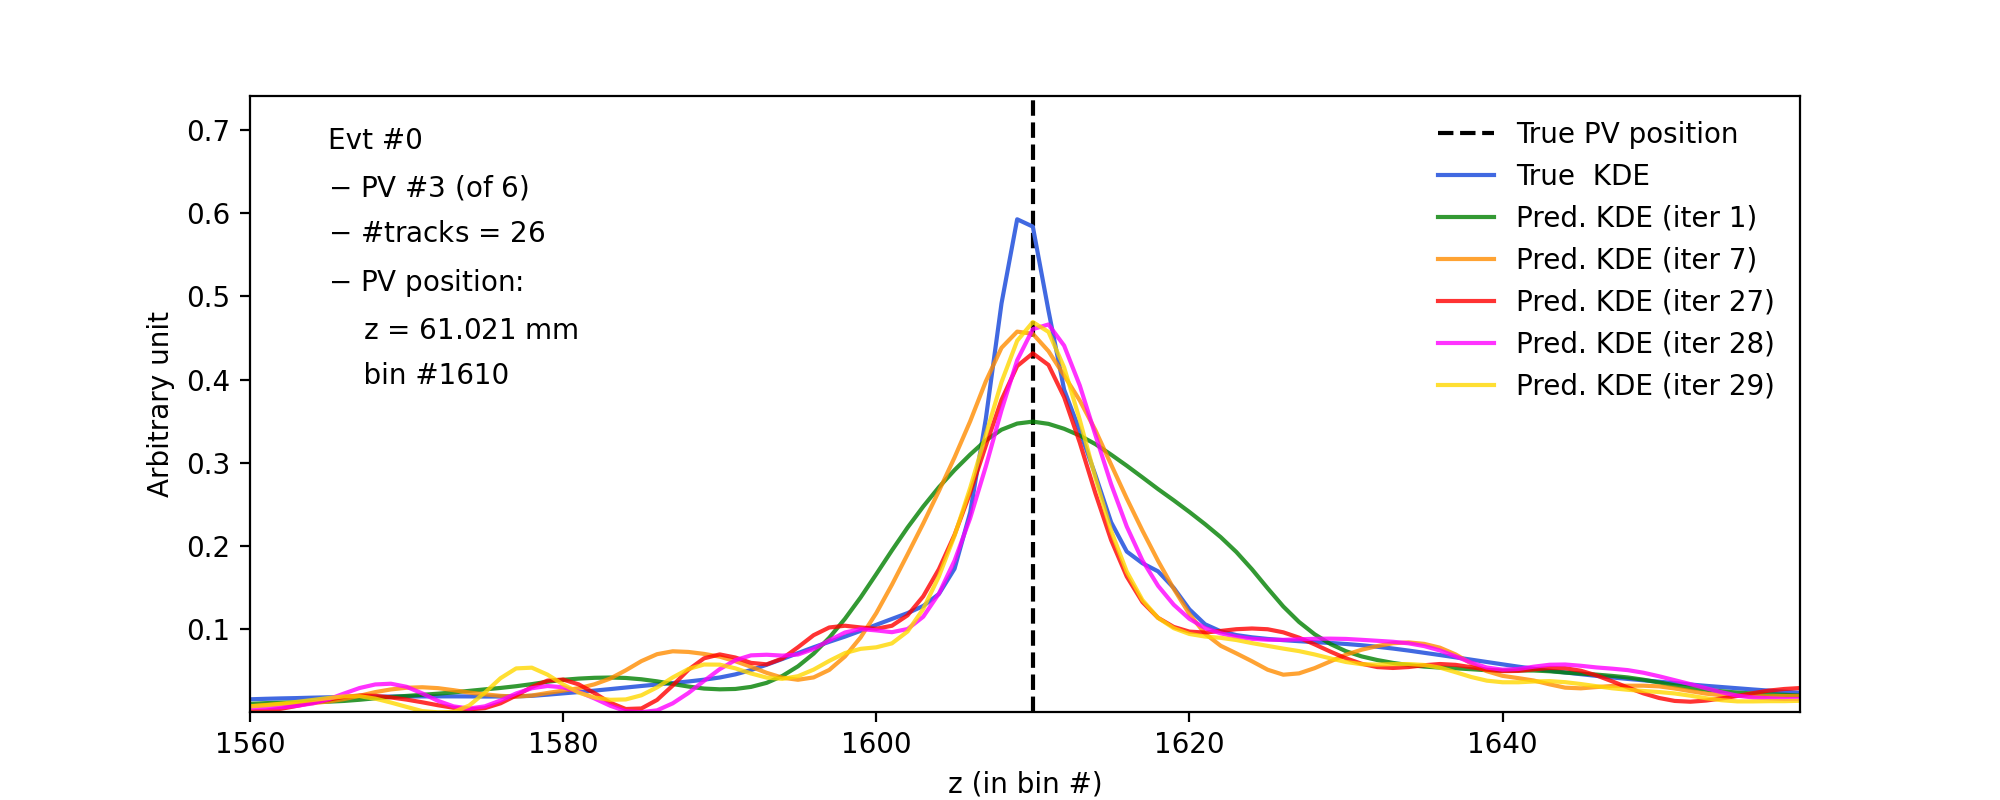

PV position and bin # =  (79.19783, 1, 19) 1791.0


<IPython.core.display.Javascript object>


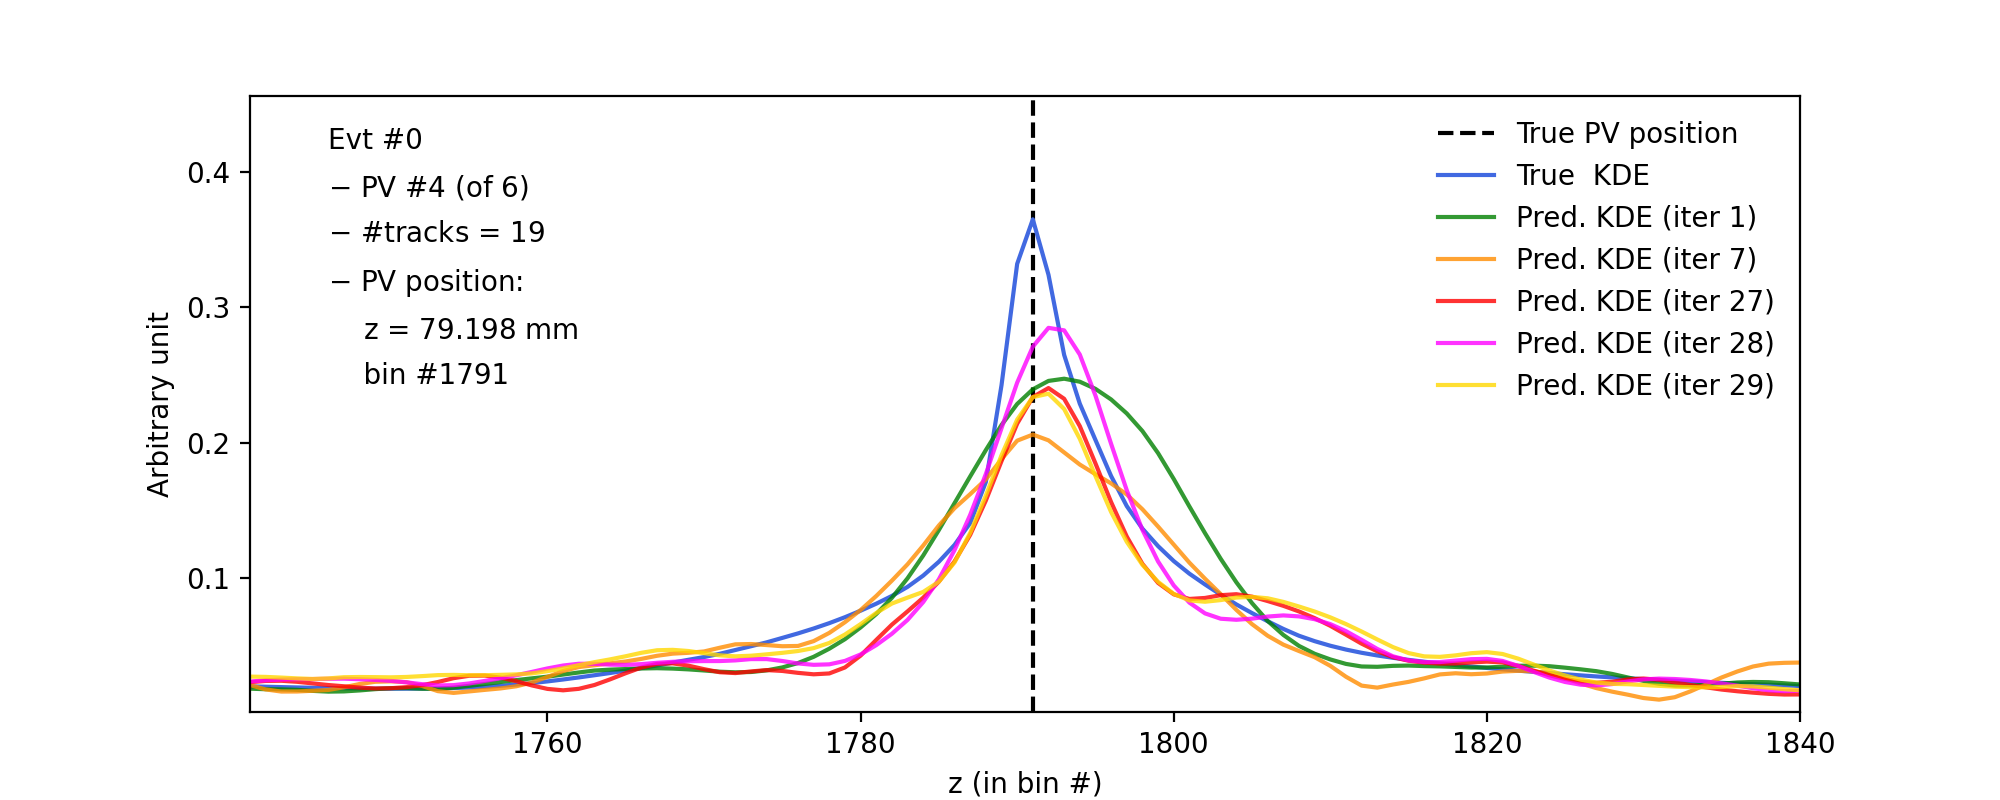

PV position and bin # =  (97.82085, 1, 24) 1978.0


<IPython.core.display.Javascript object>


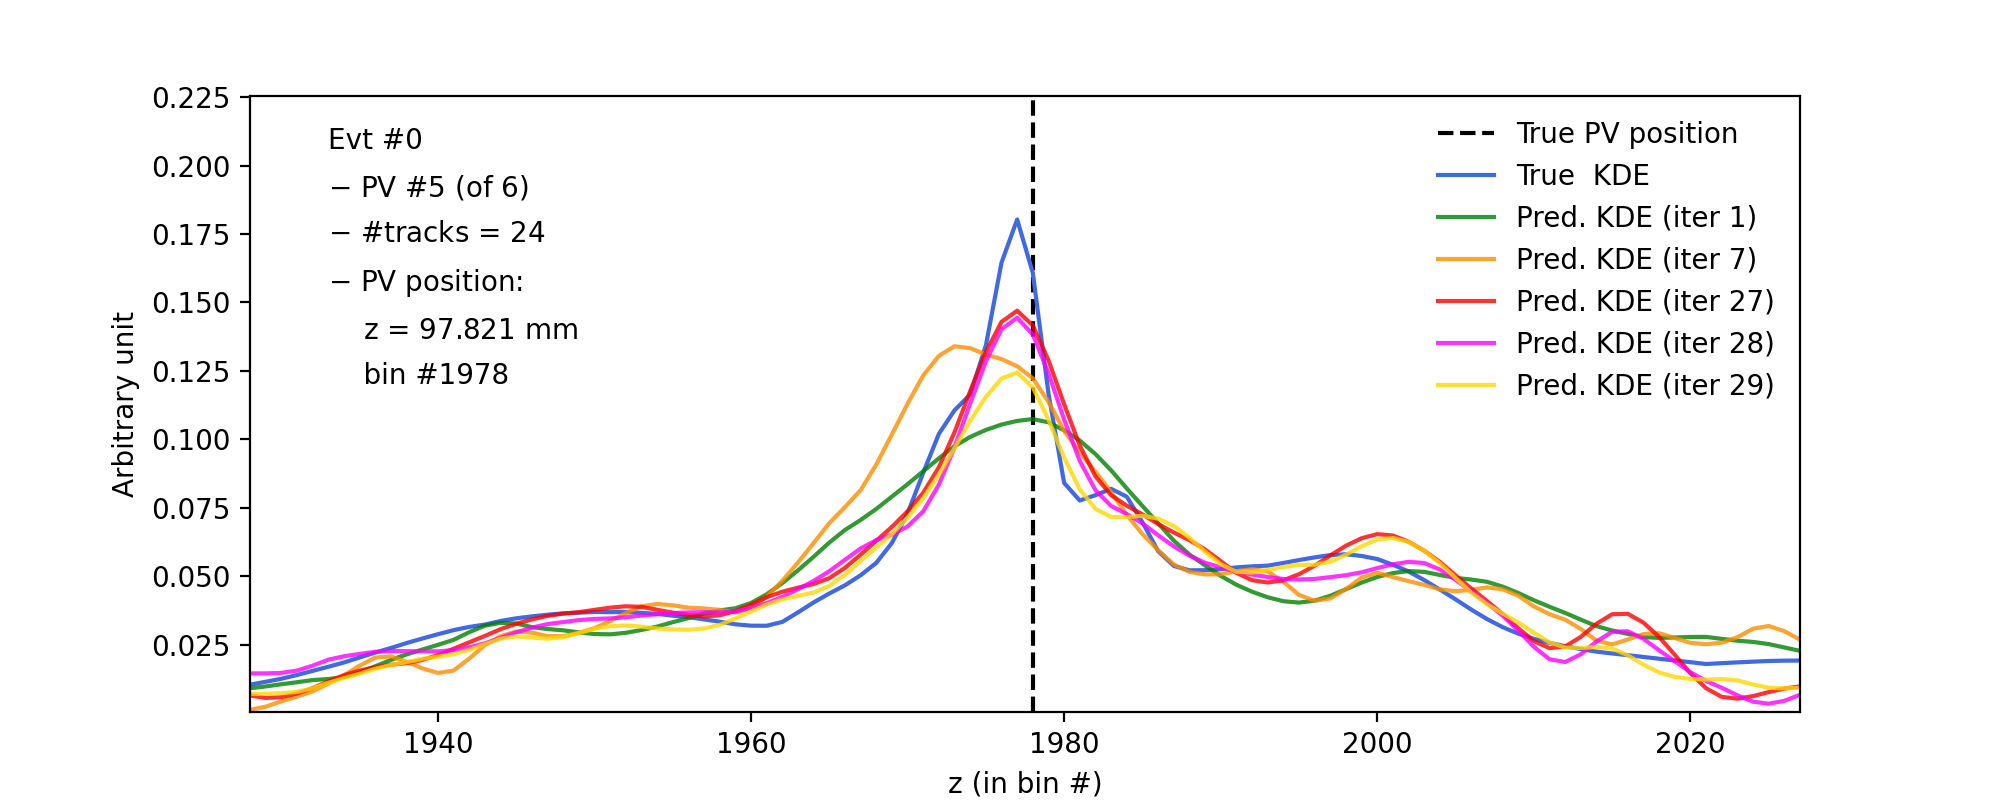

PV position and bin # =  (134.26784, 1, 7) 2342.0


<IPython.core.display.Javascript object>


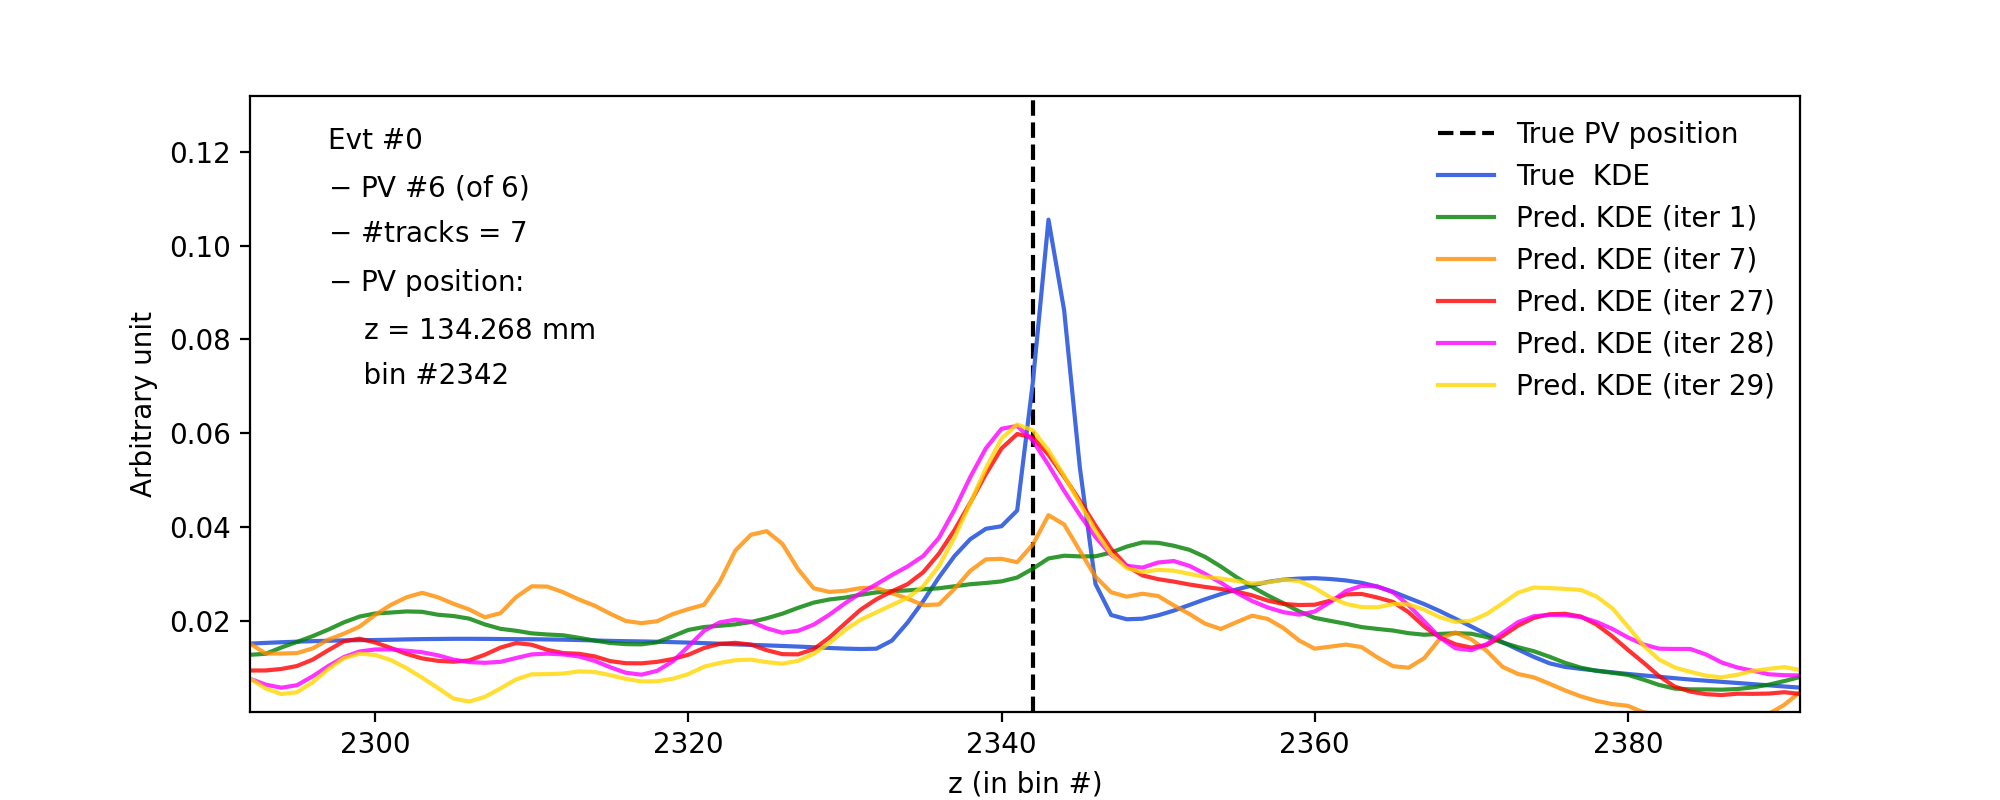

iEvt =  1


<IPython.core.display.Javascript object>


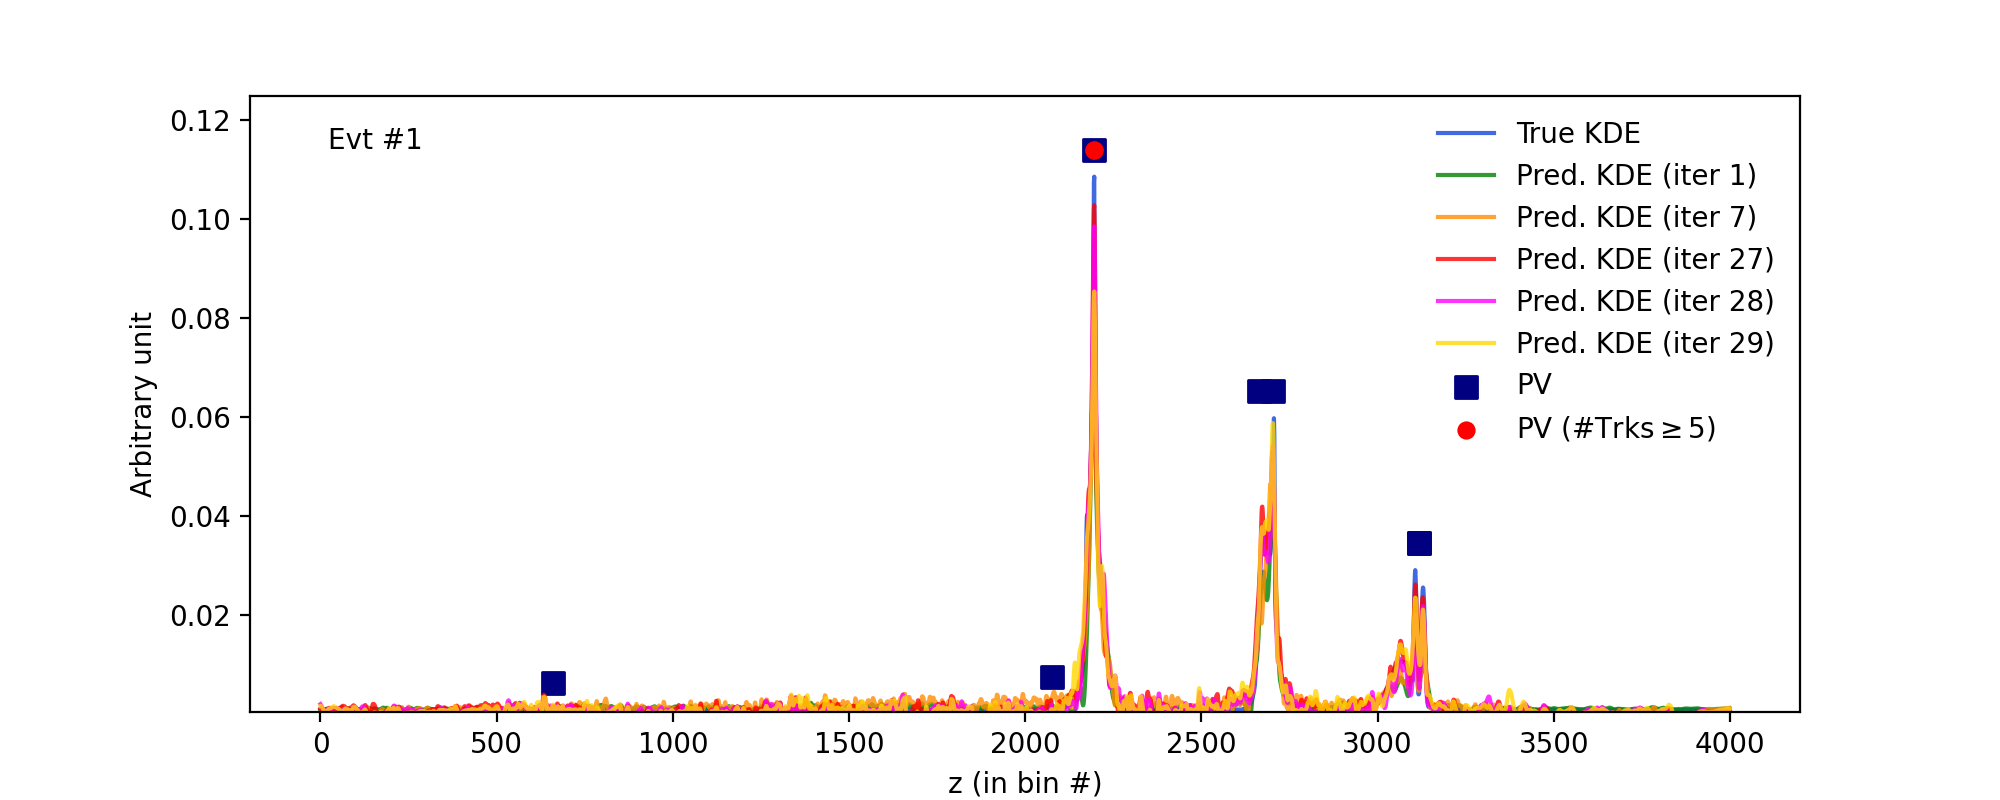

PV position and bin # =  (119.57261, 1, 7) 2195.0


<IPython.core.display.Javascript object>


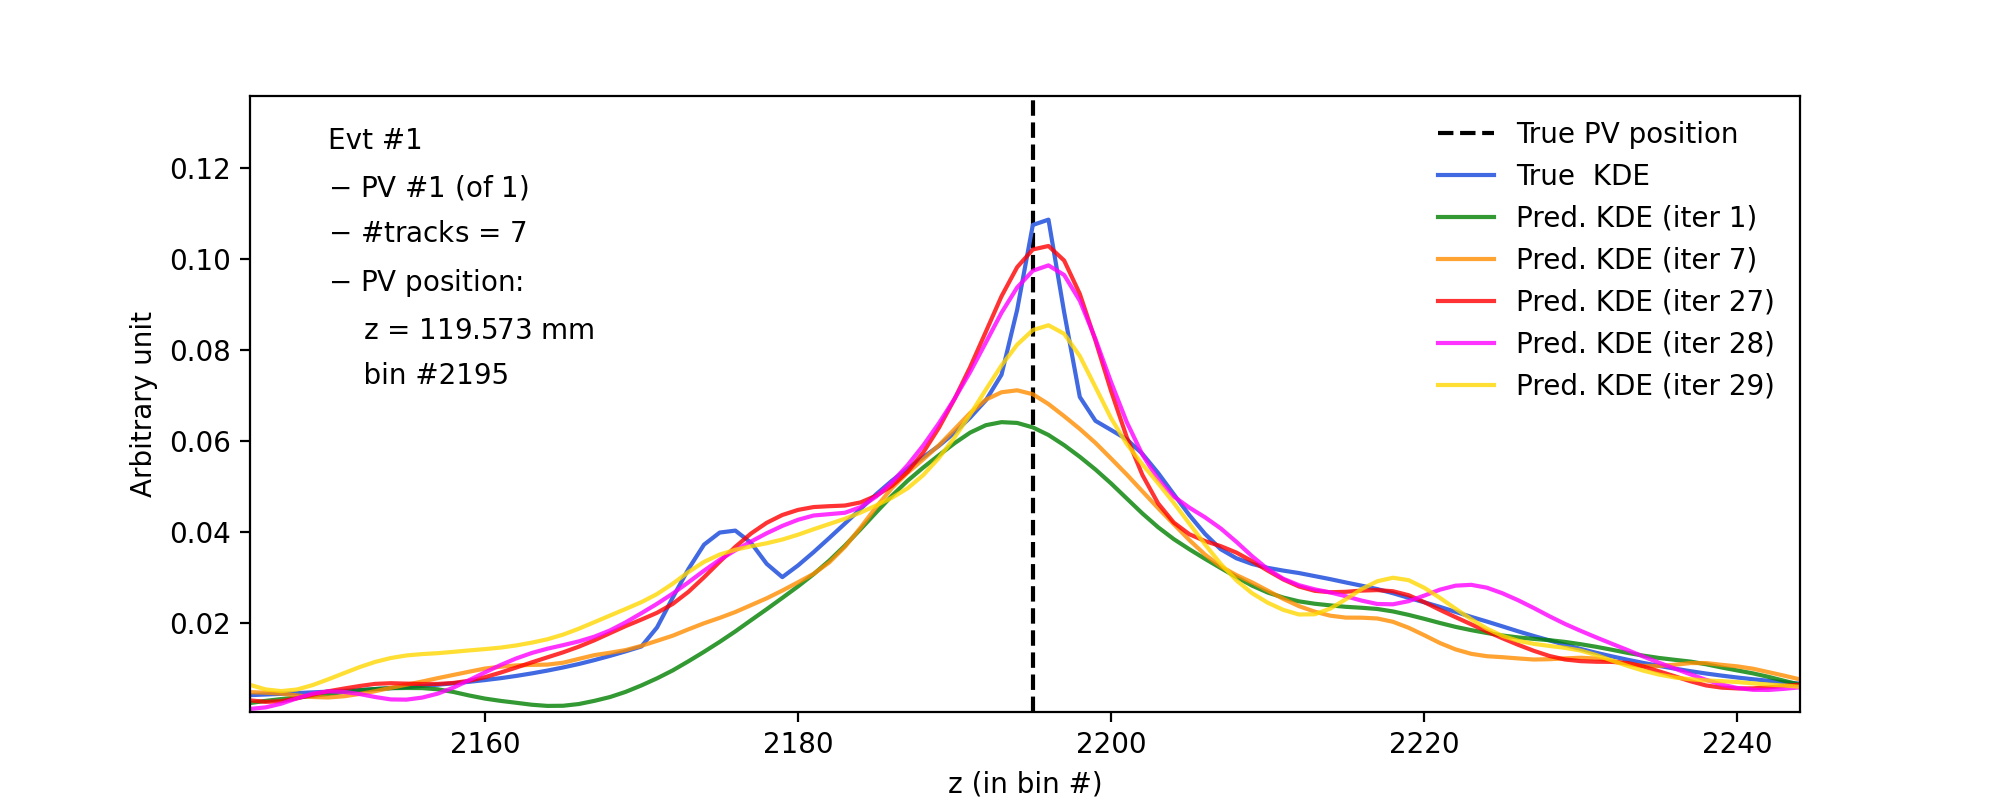

iEvt =  2


<IPython.core.display.Javascript object>


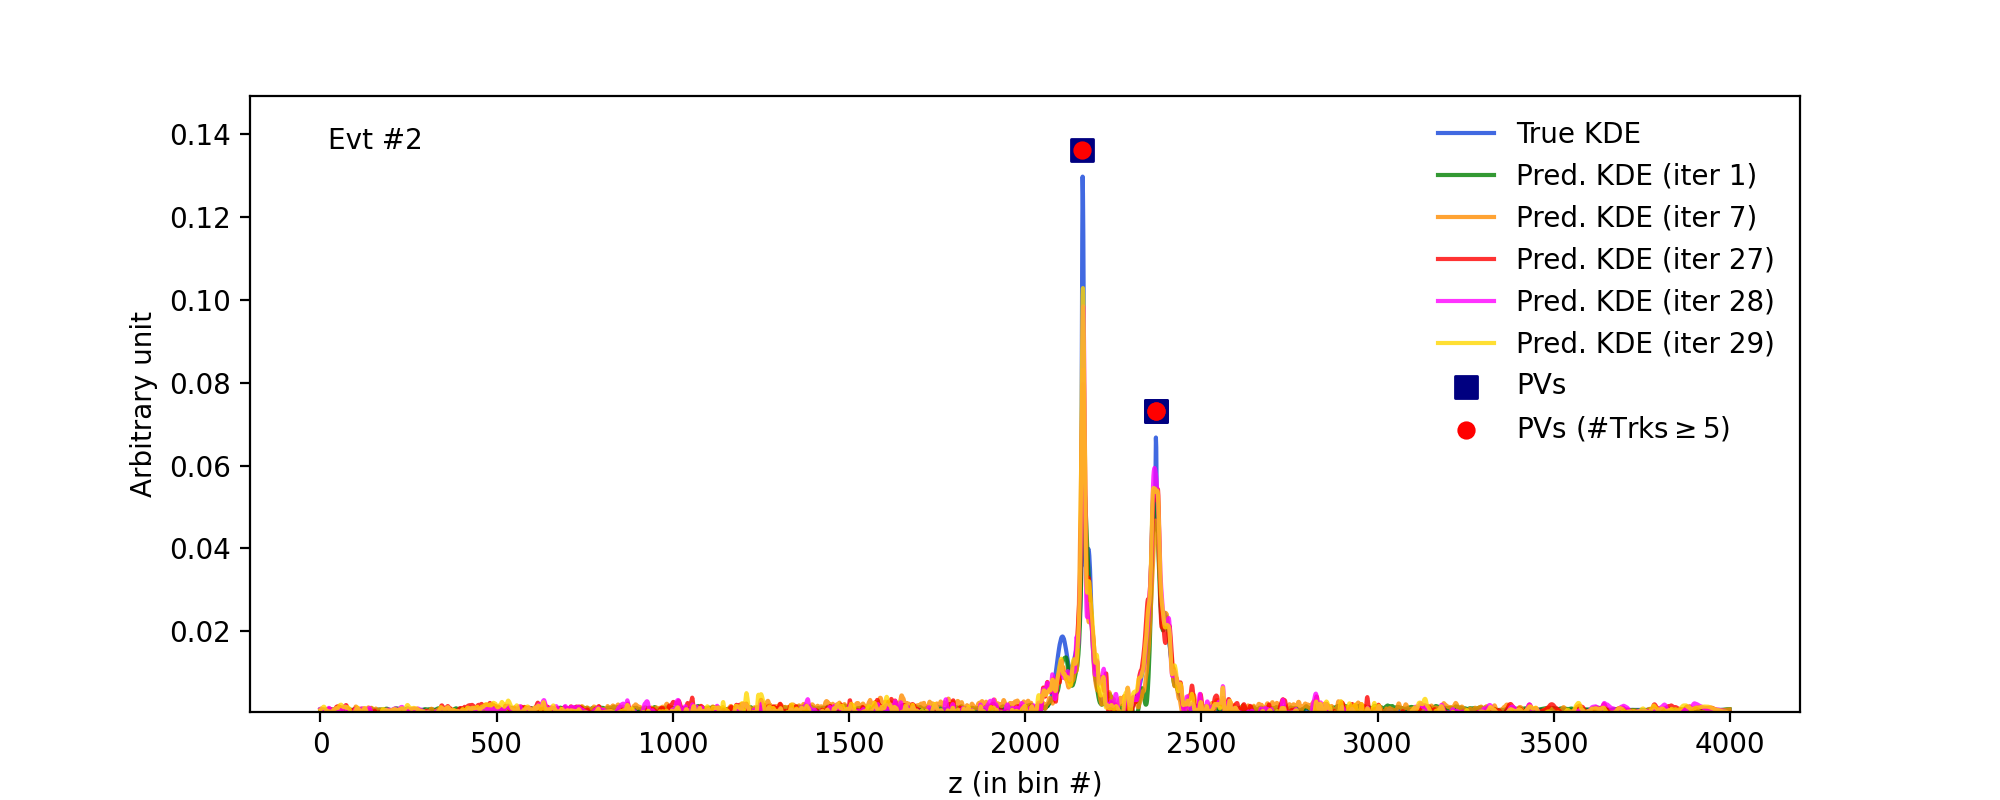

PV position and bin # =  (116.2301, 1, 5) 2162.0


<IPython.core.display.Javascript object>


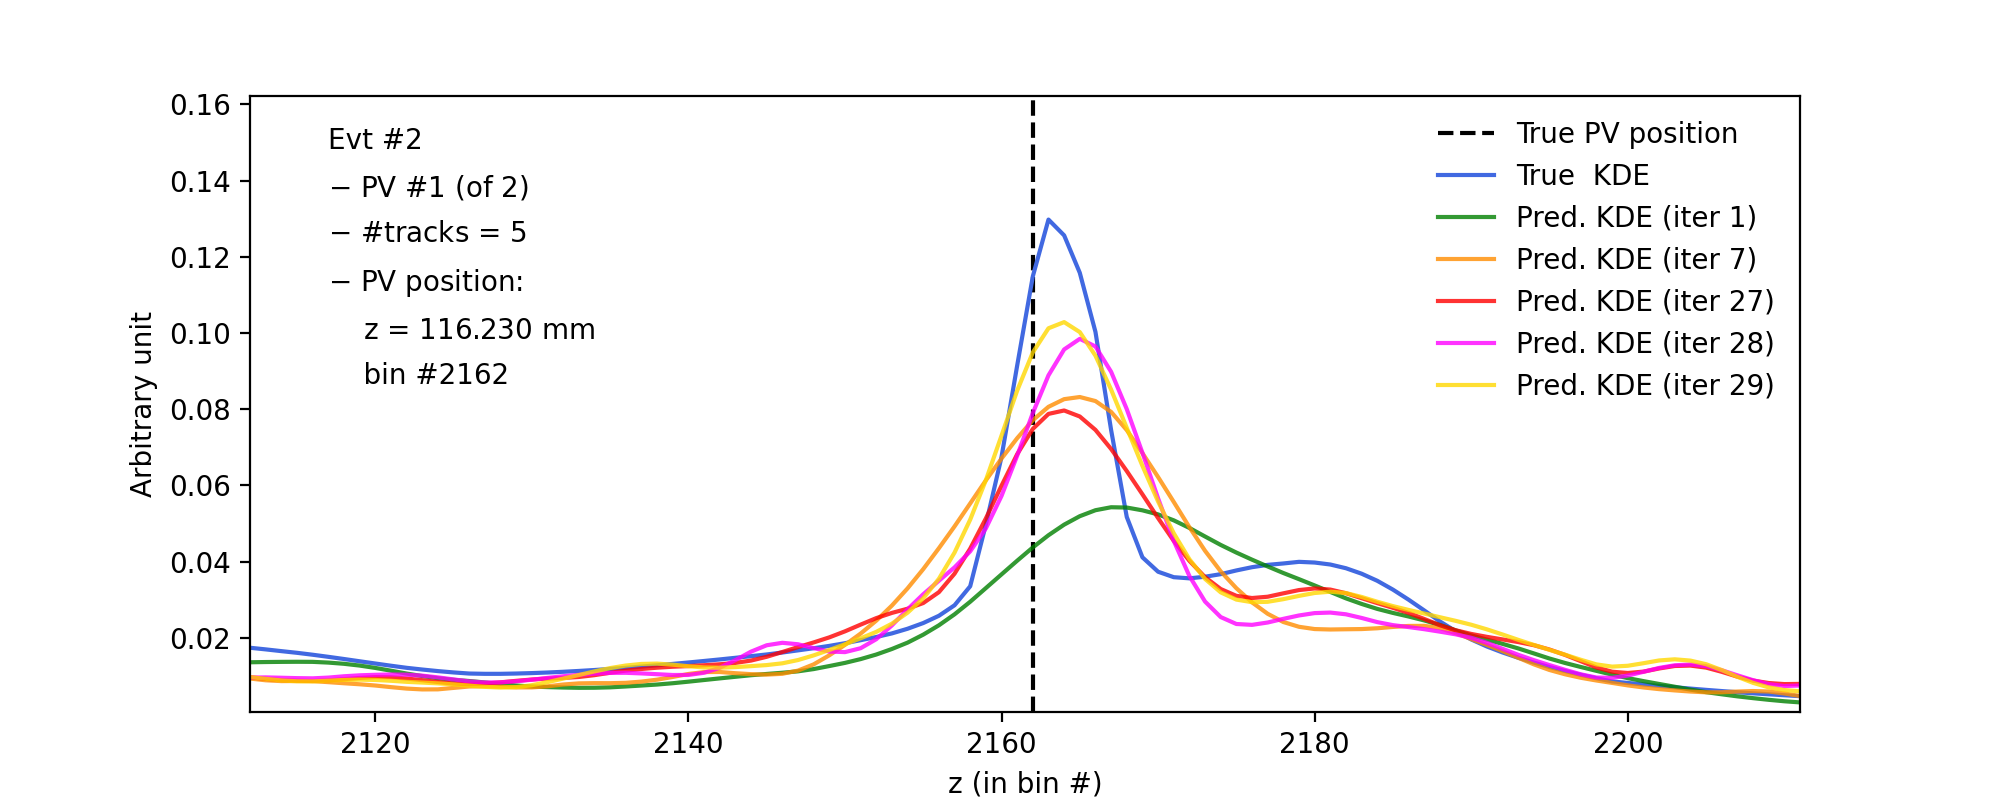

PV position and bin # =  (137.23302, 1, 7) 2372.0


<IPython.core.display.Javascript object>


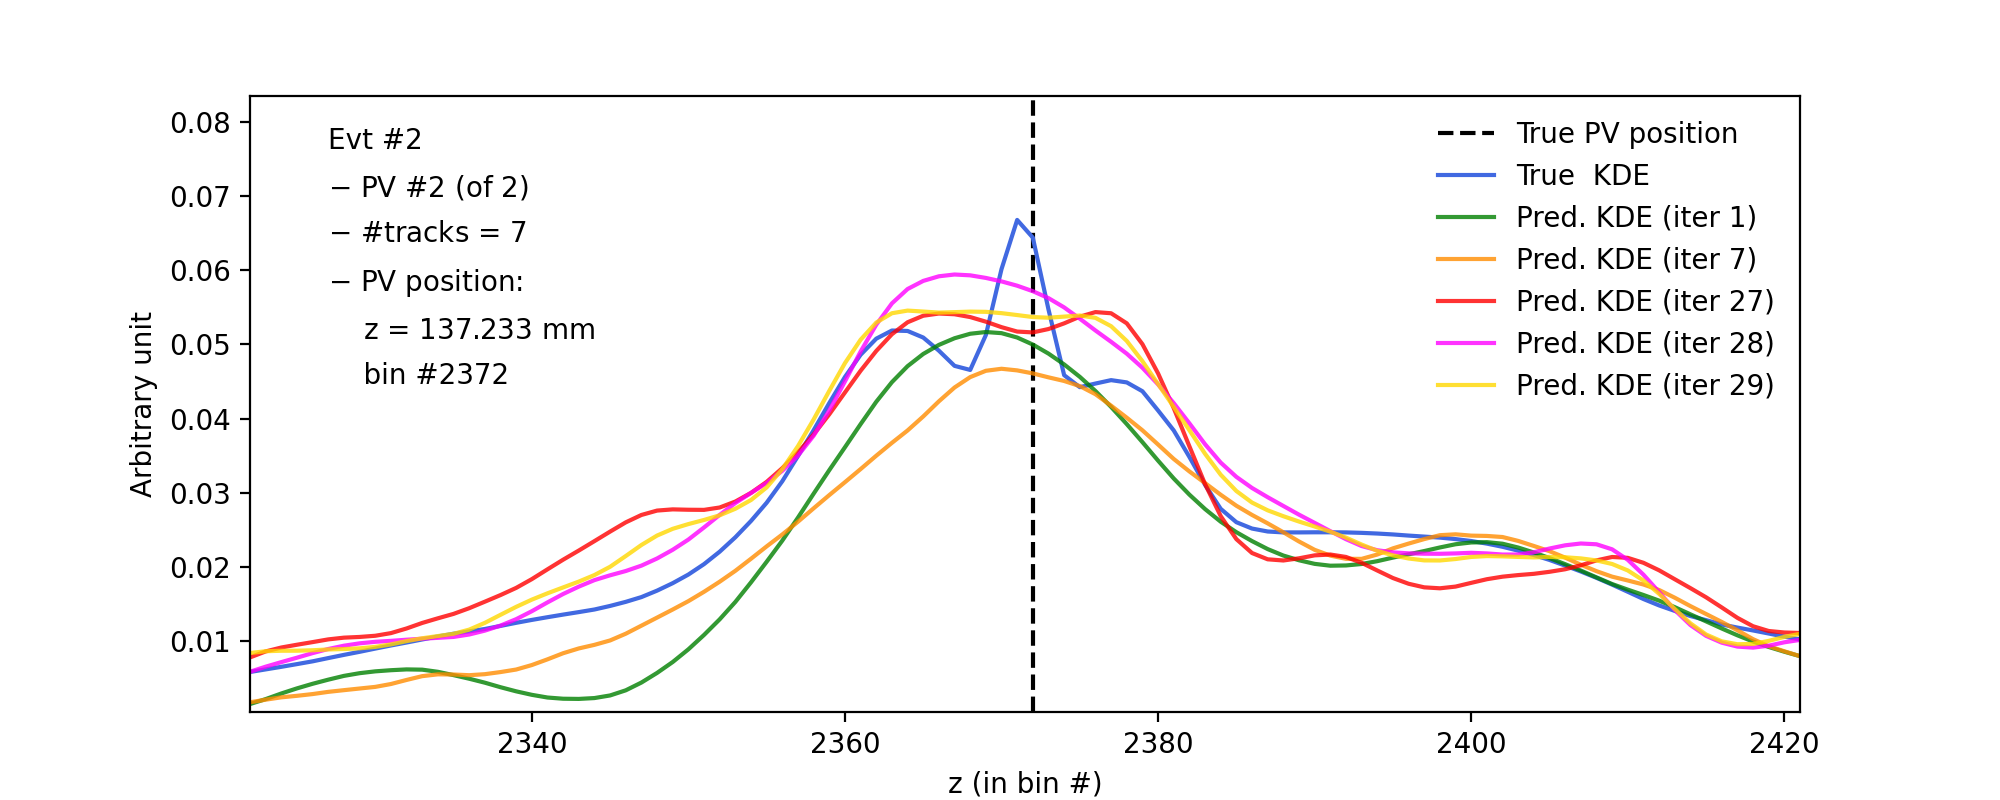

iEvt =  3


<IPython.core.display.Javascript object>


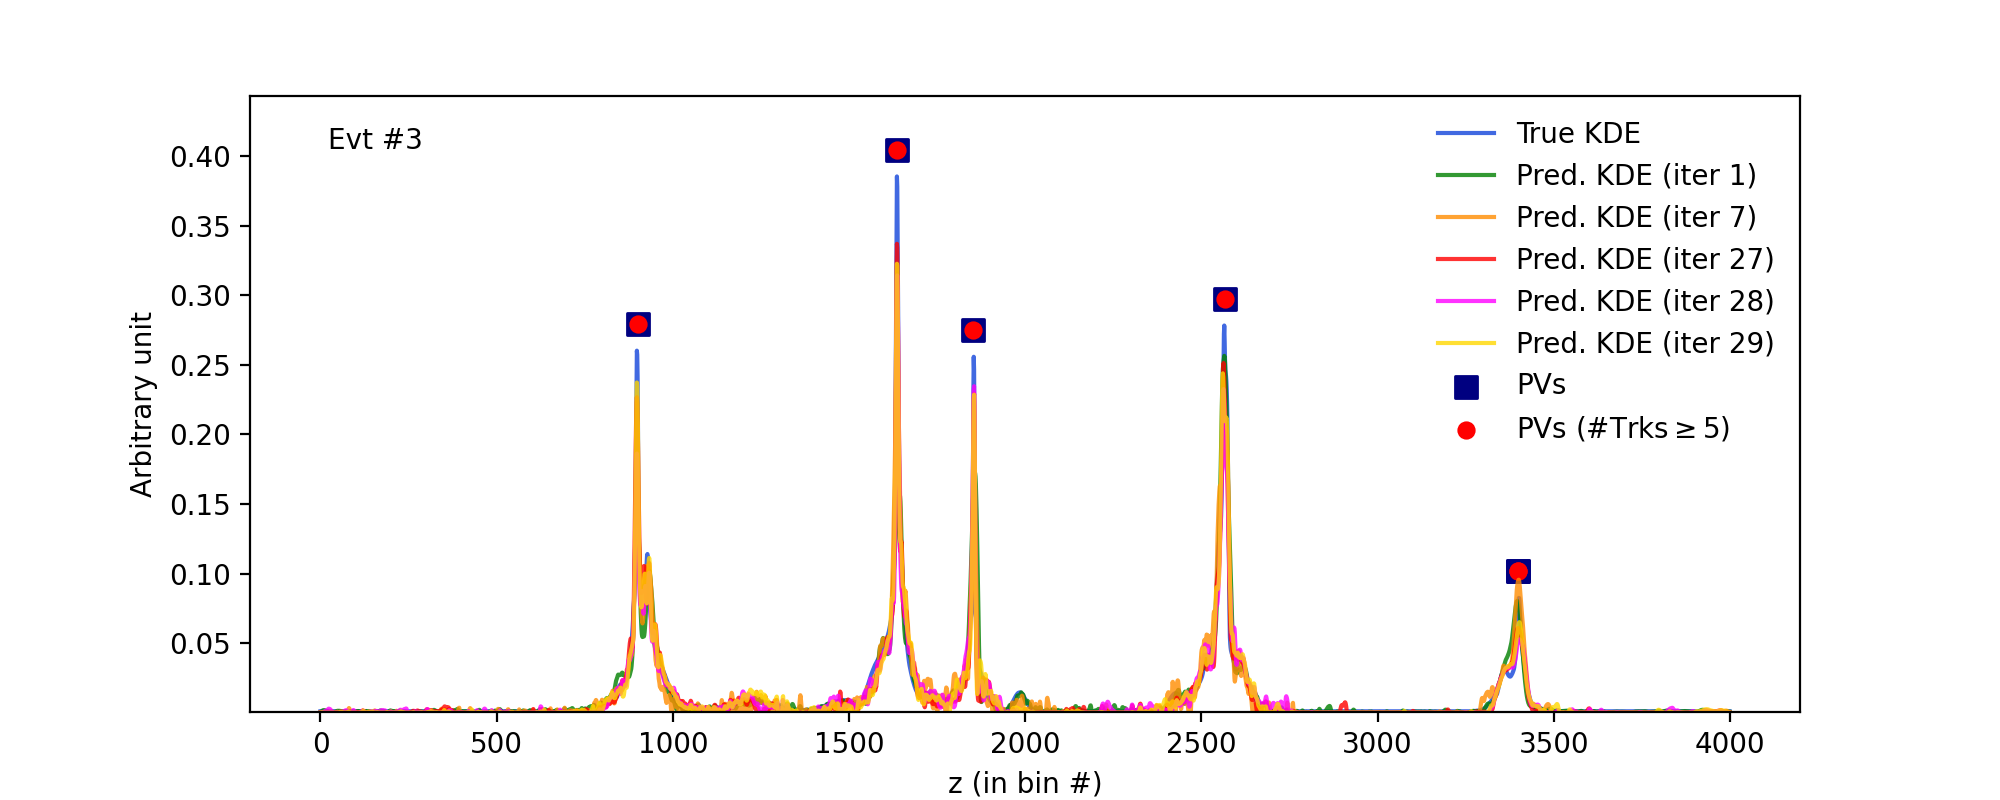

PV position and bin # =  (-9.917648, 1, 25) 900.0


<IPython.core.display.Javascript object>


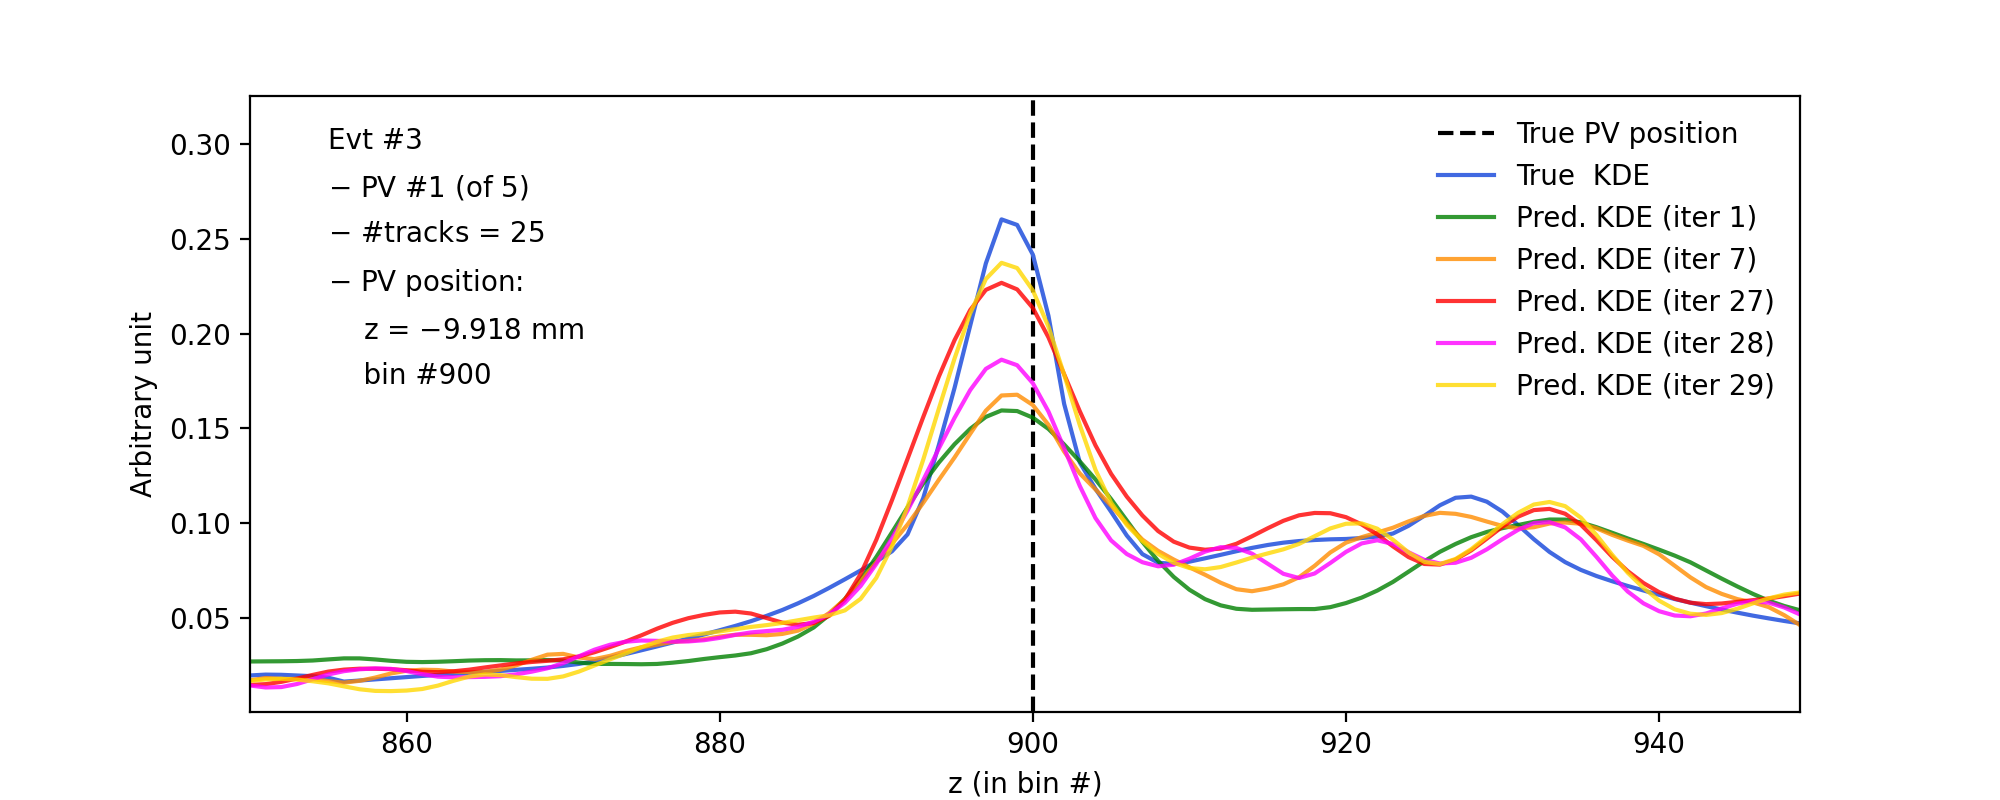

PV position and bin # =  (63.546913, 1, 28) 1635.0


<IPython.core.display.Javascript object>


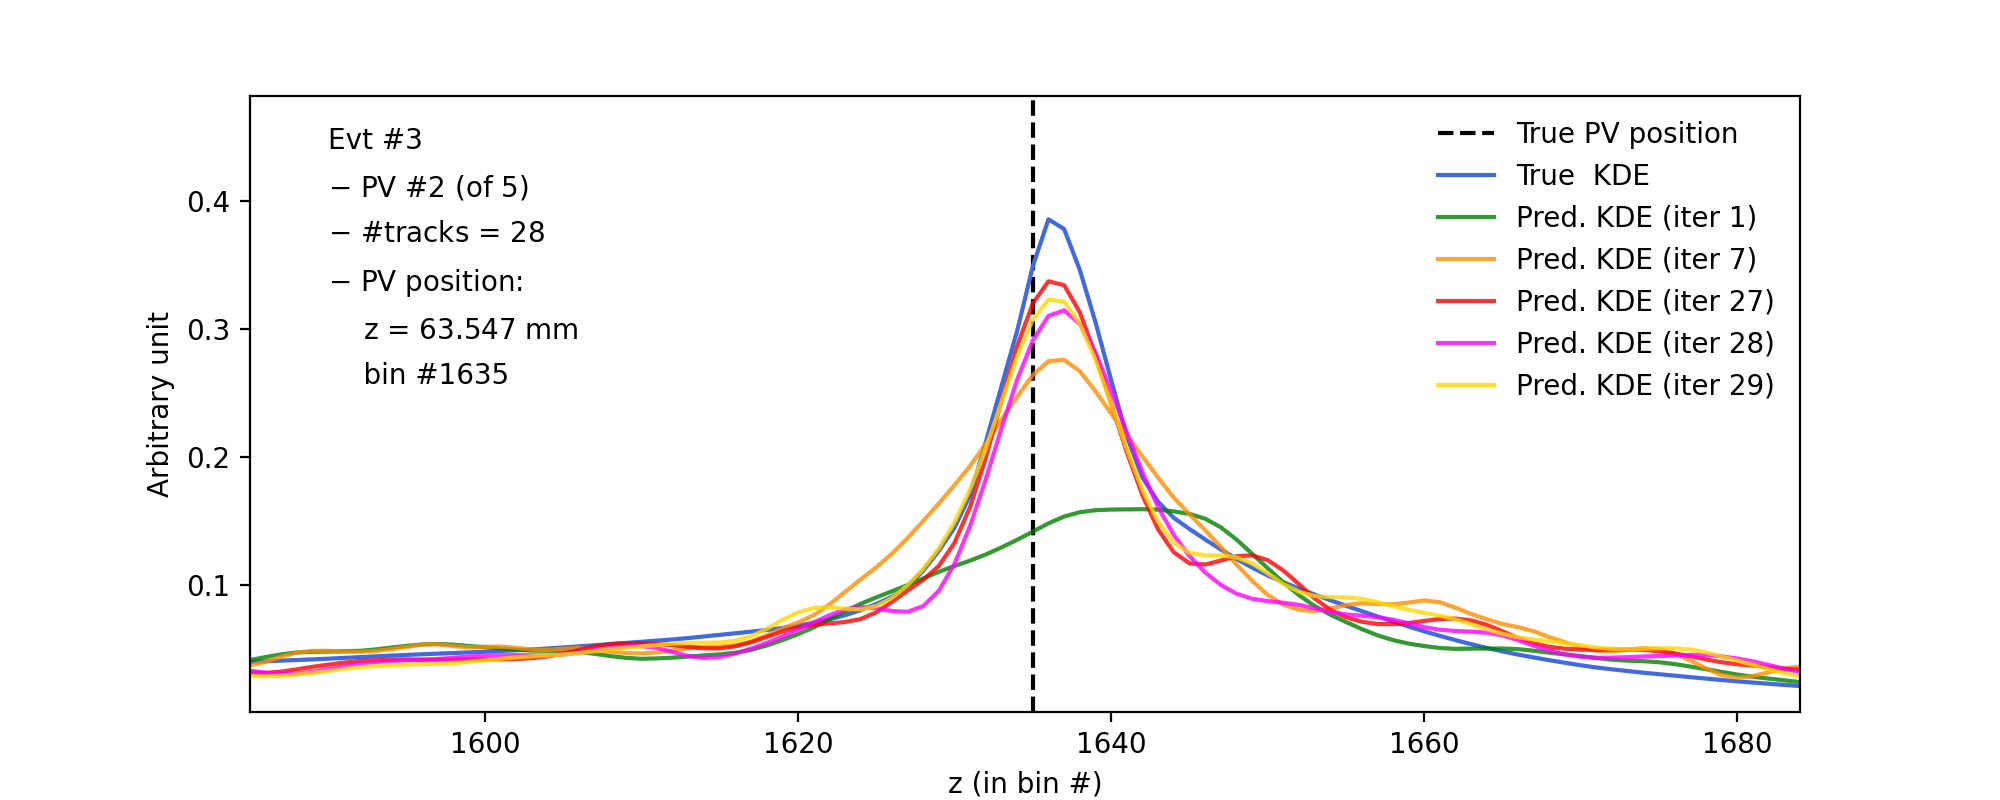

PV position and bin # =  (85.381065, 1, 13) 1853.0


<IPython.core.display.Javascript object>


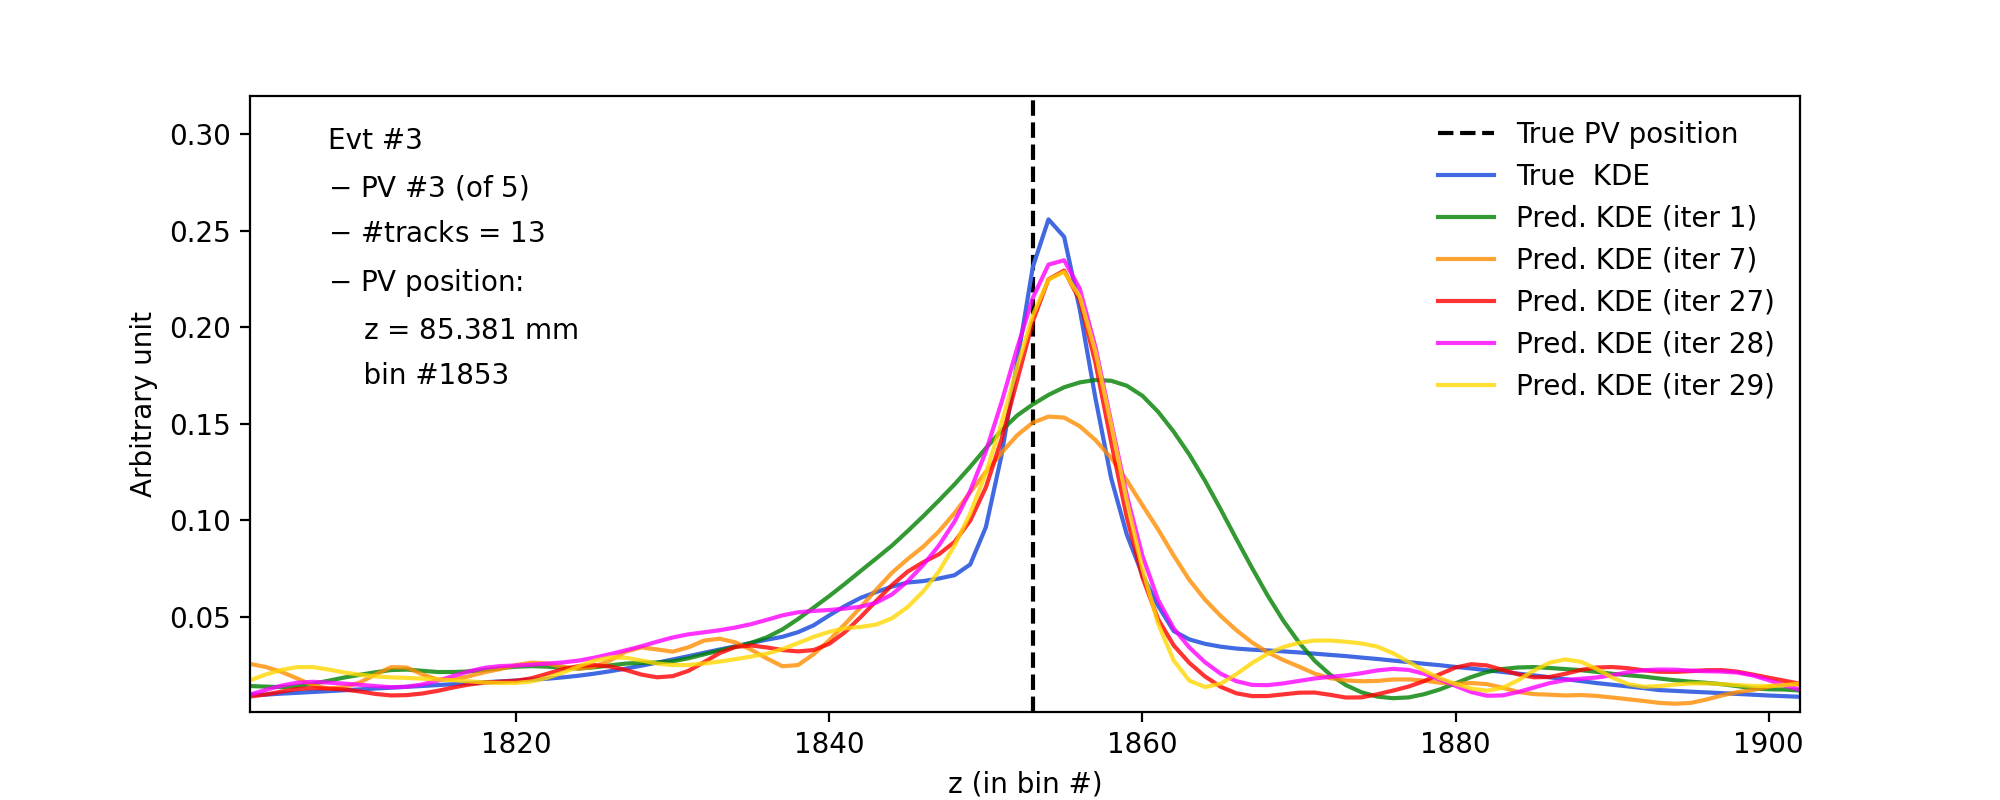

PV position and bin # =  (156.8066, 1, 42) 2568.0


<IPython.core.display.Javascript object>


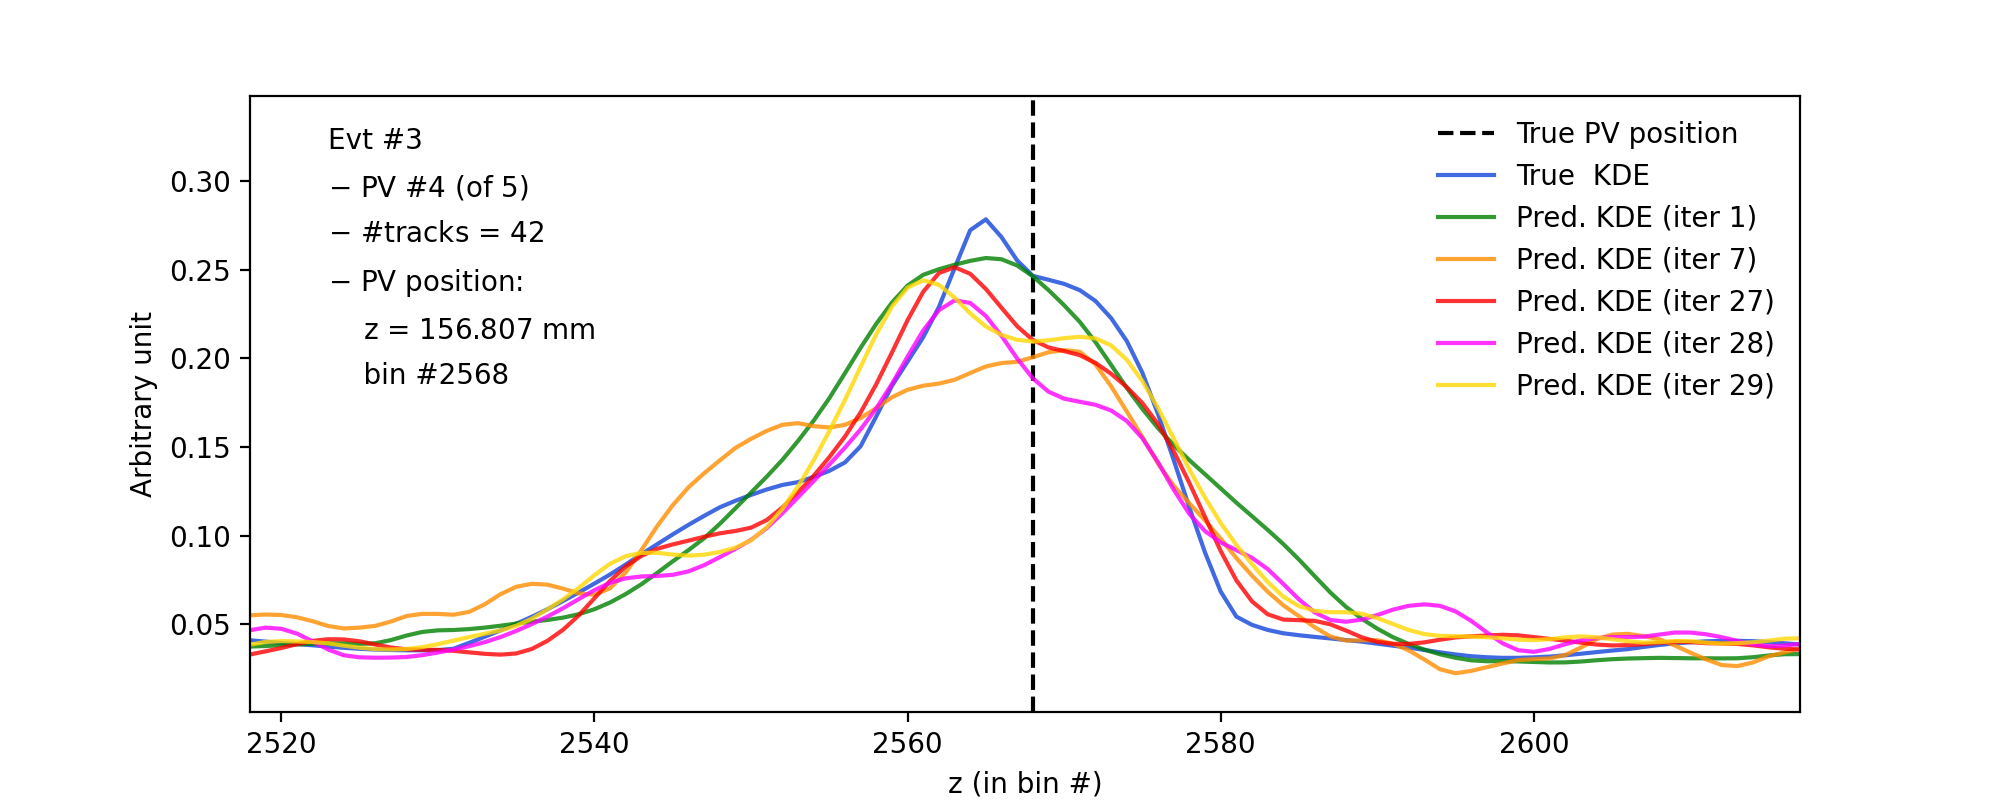

PV position and bin # =  (239.98242, 1, 11) 3399.0


<IPython.core.display.Javascript object>


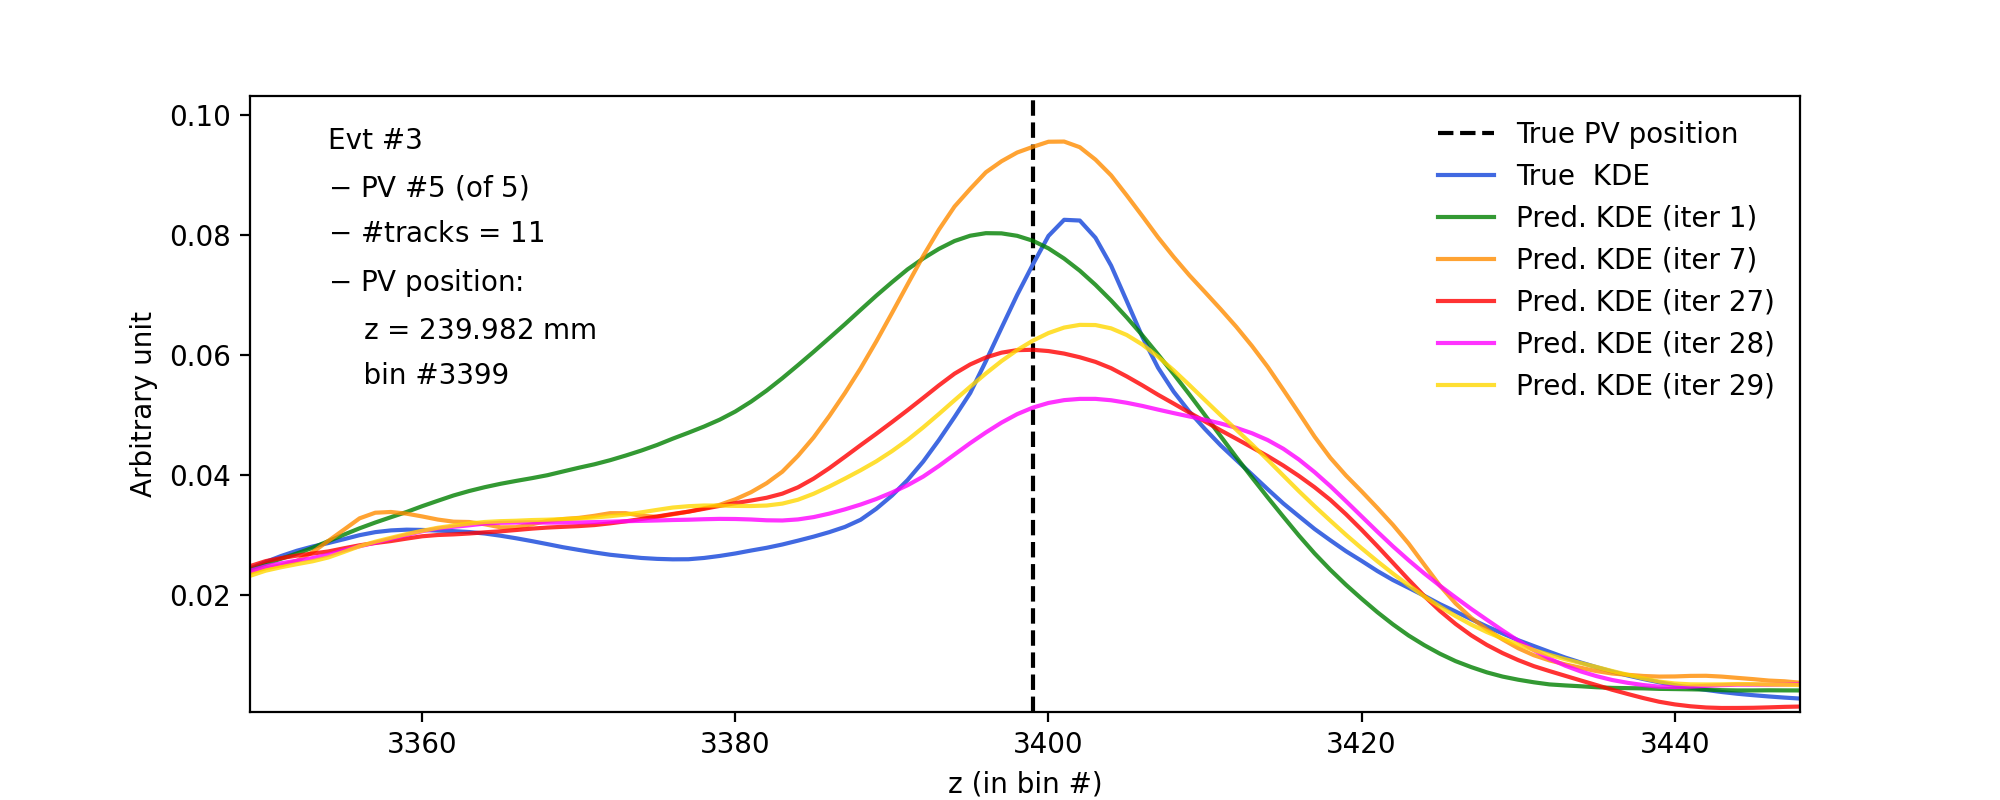

iEvt =  4


<IPython.core.display.Javascript object>


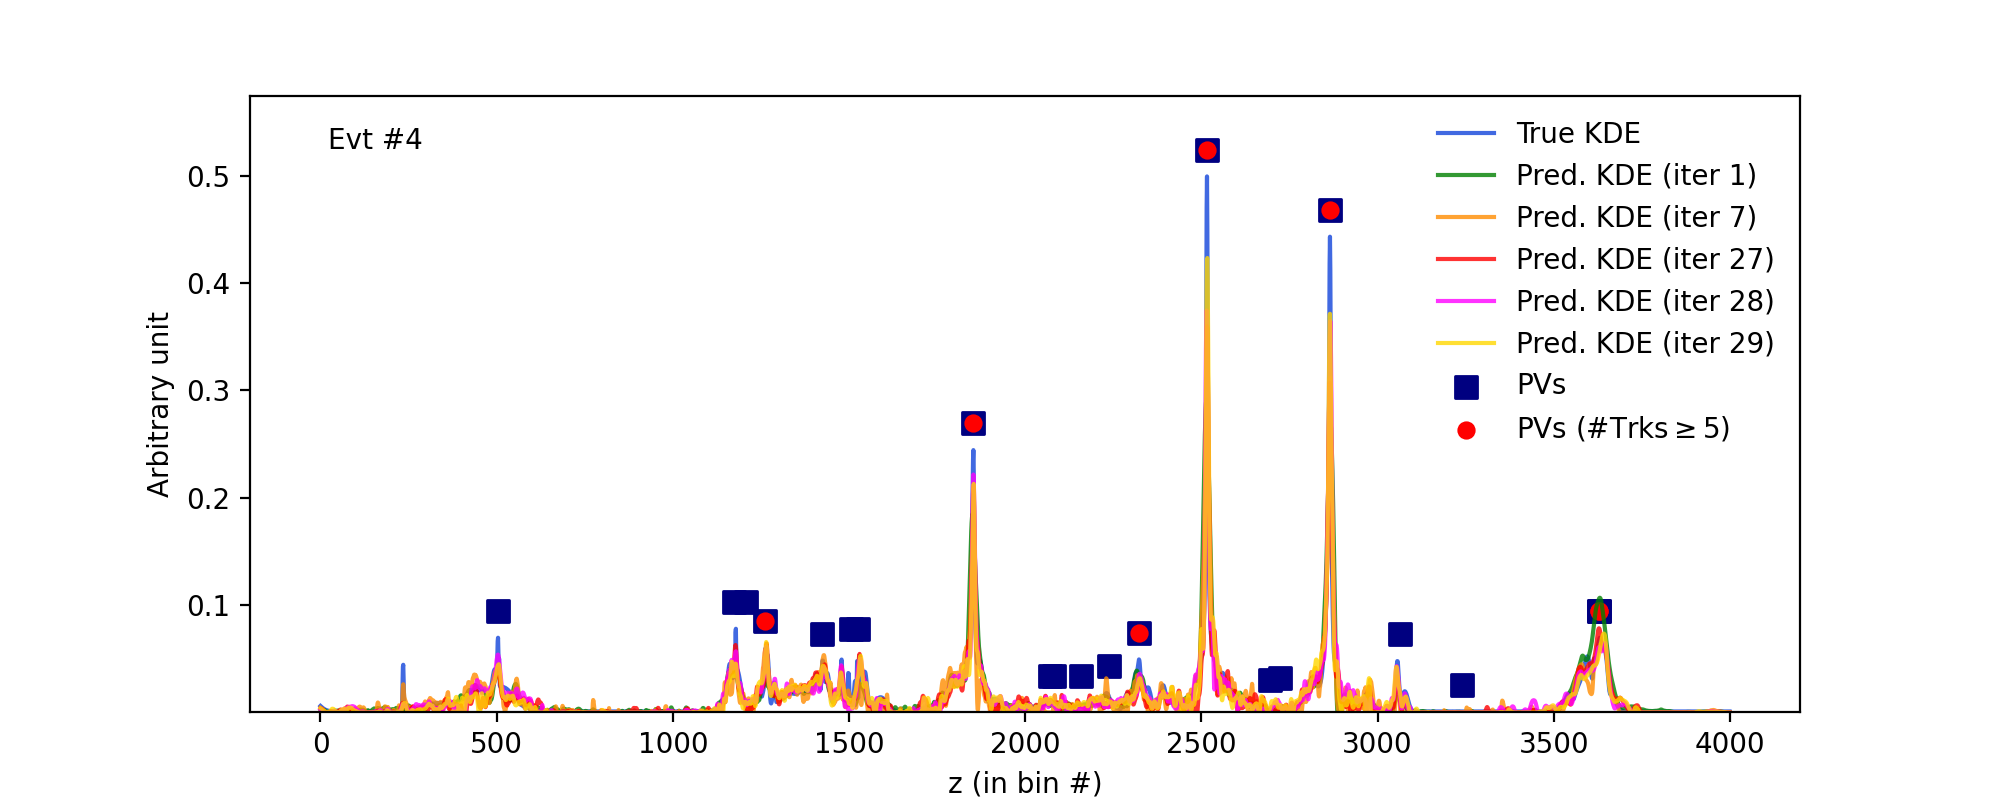

PV position and bin # =  (26.315554, 1, 7) 1263.0


<IPython.core.display.Javascript object>


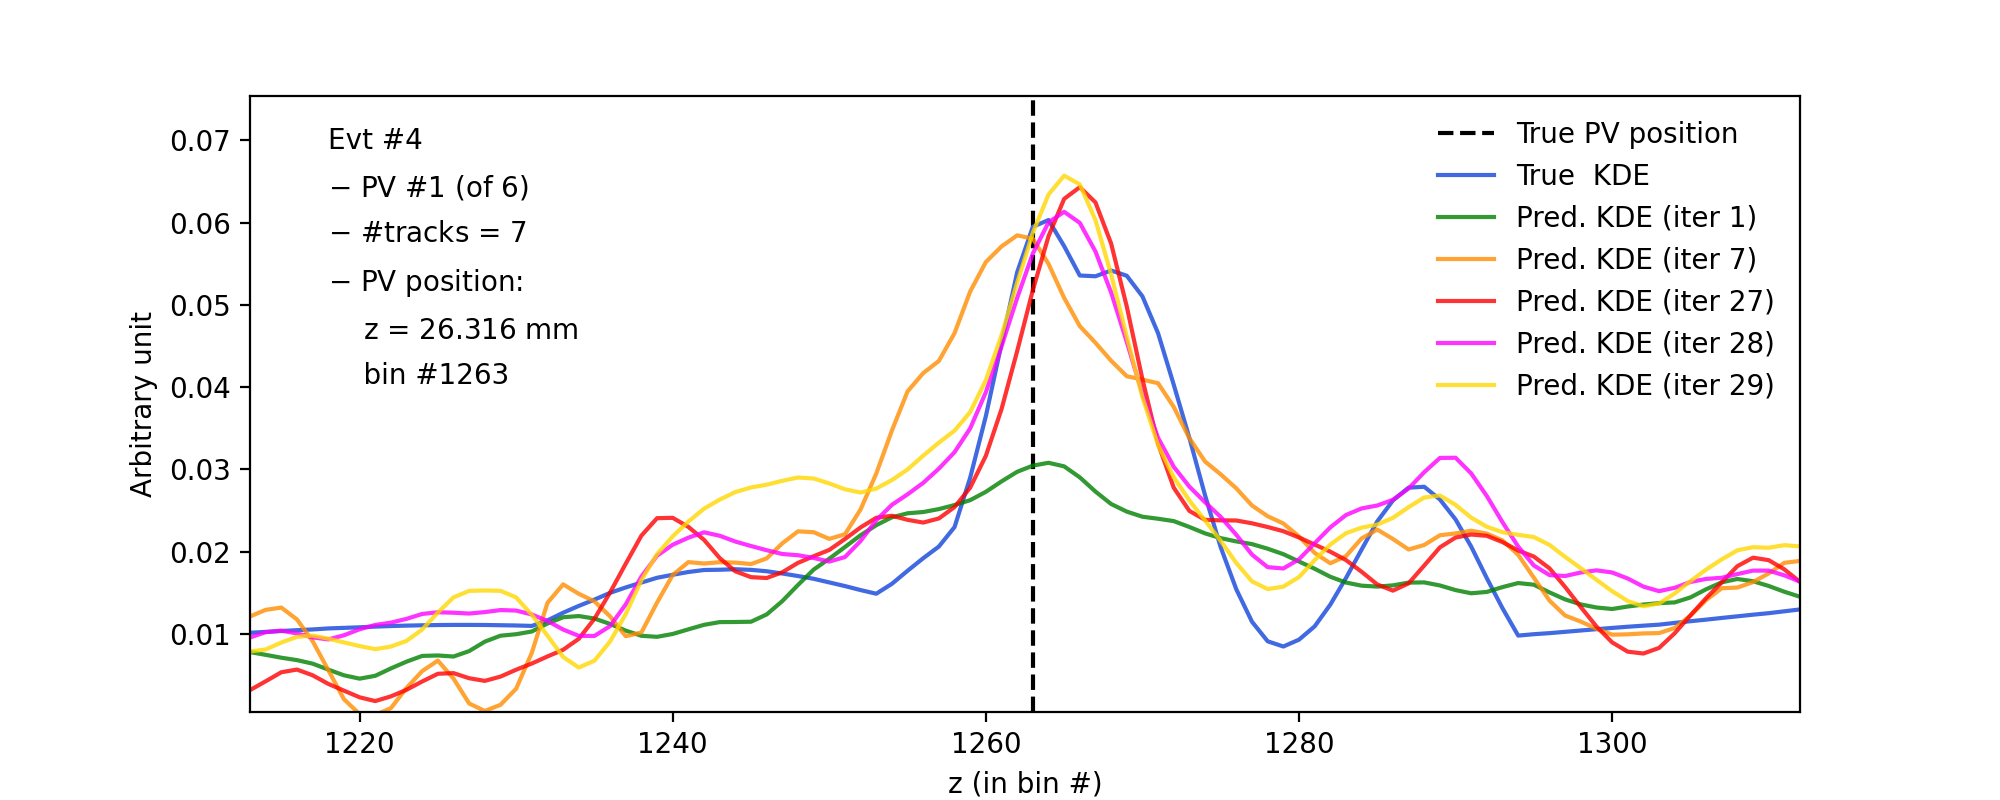

PV position and bin # =  (85.32848, 1, 17) 1853.0


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


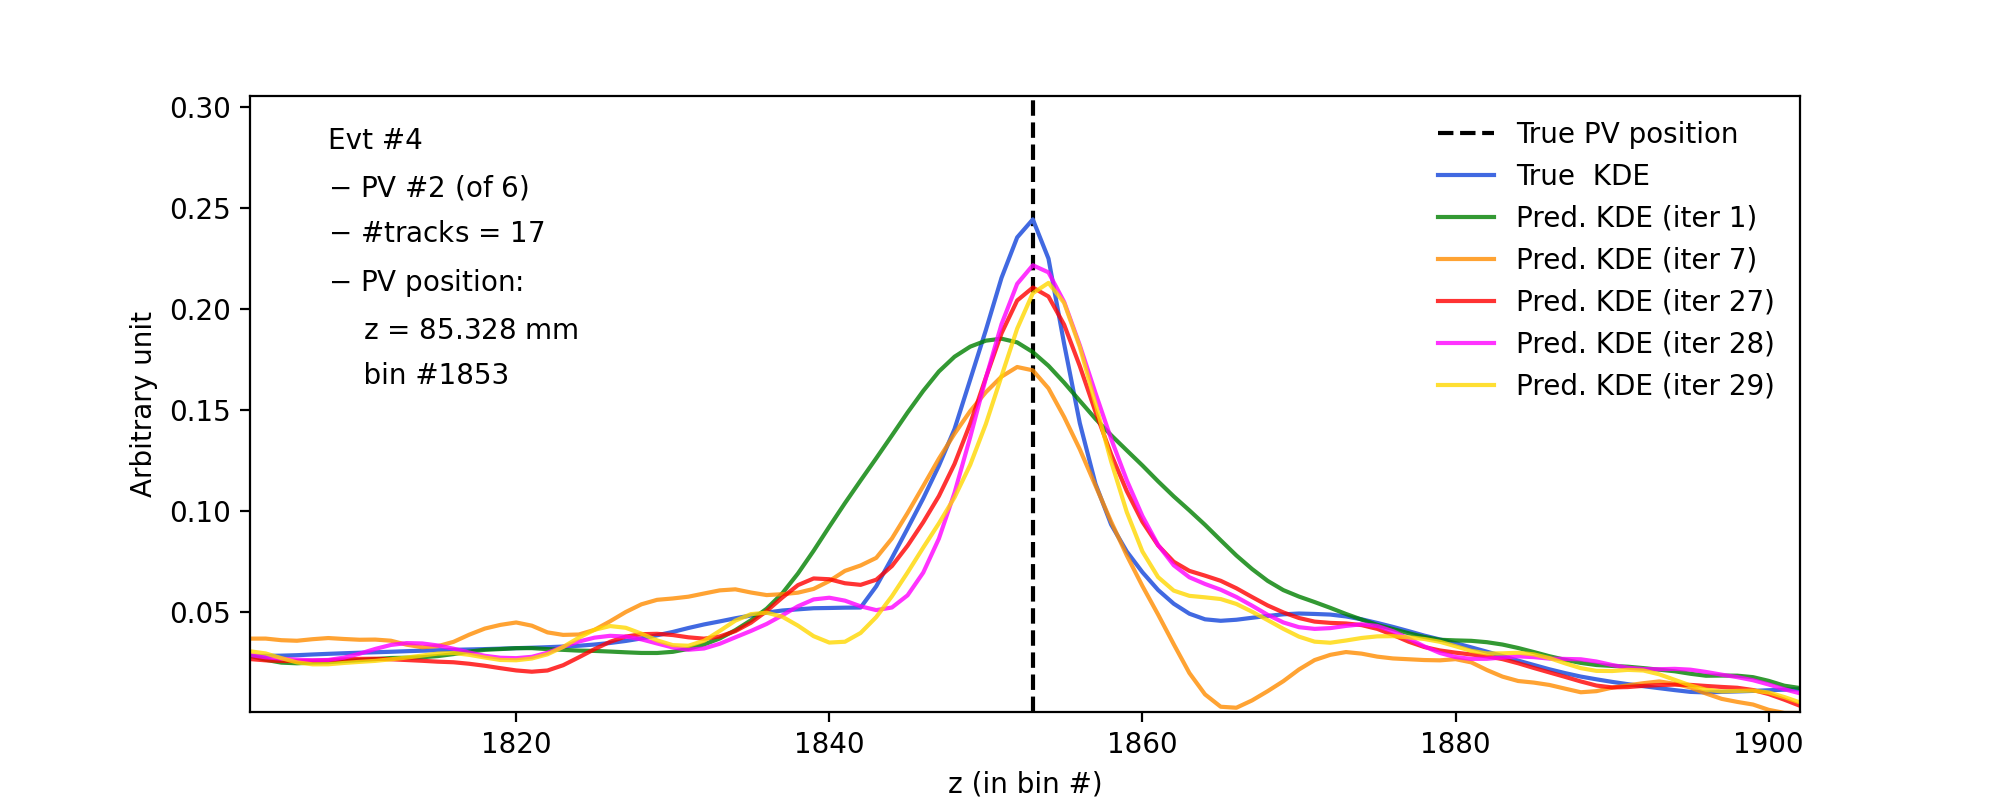

PV position and bin # =  (132.24886, 1, 7) 2322.0


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


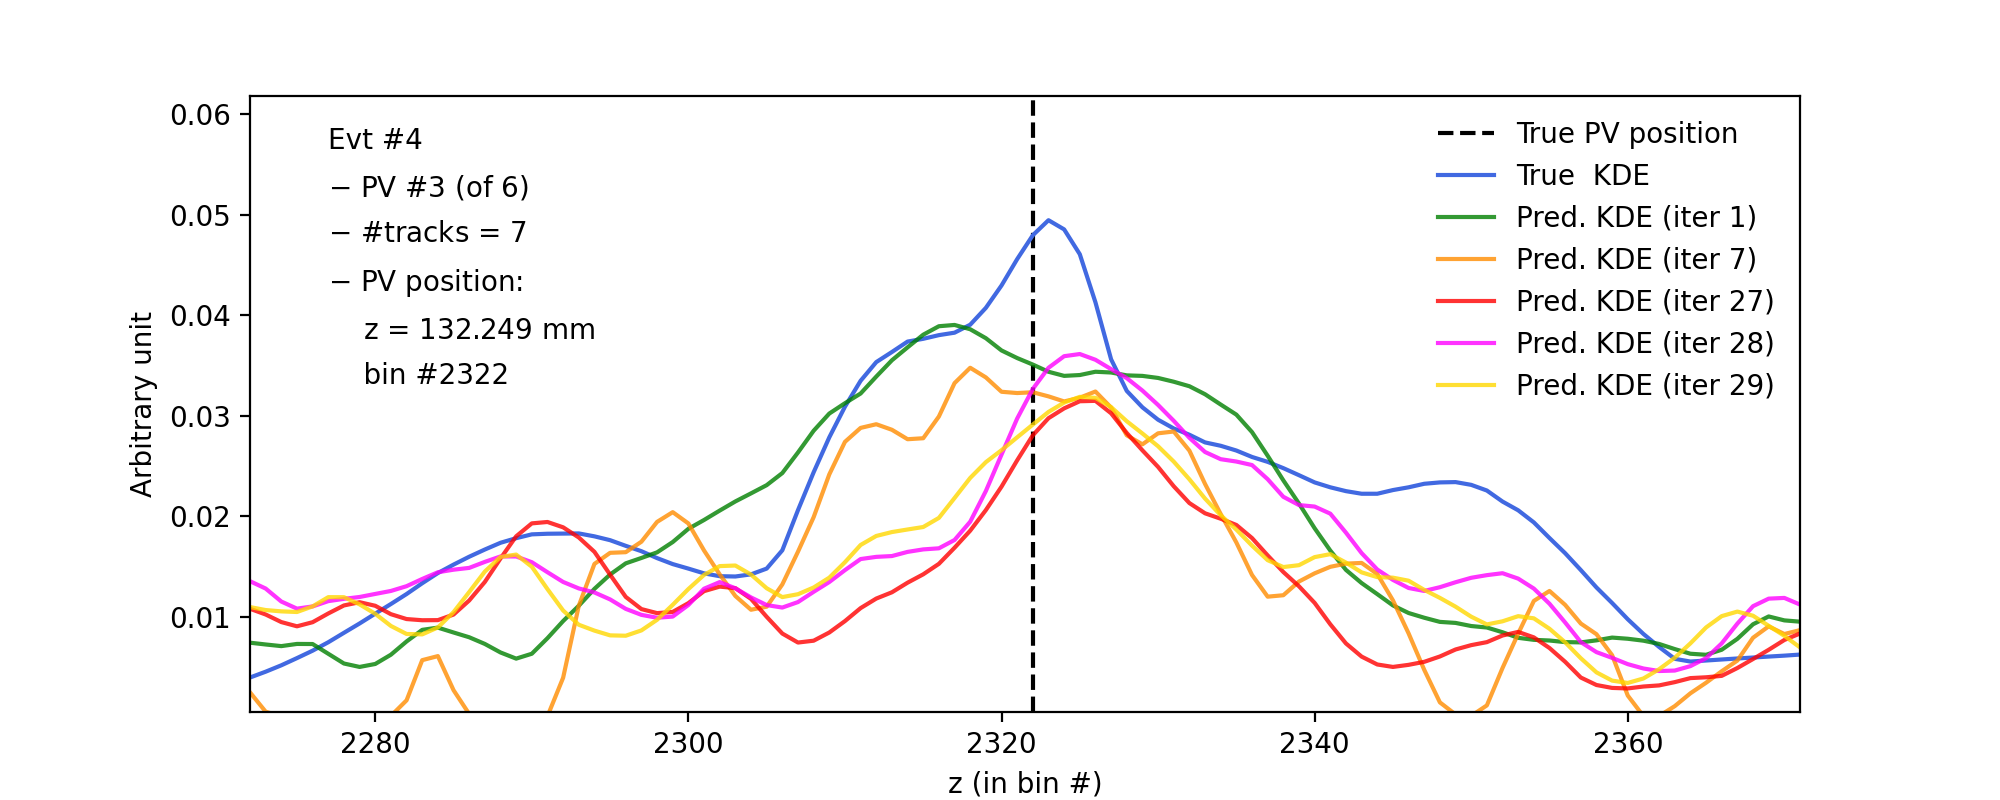

PV position and bin # =  (151.79068, 1, 22) 2517.0


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


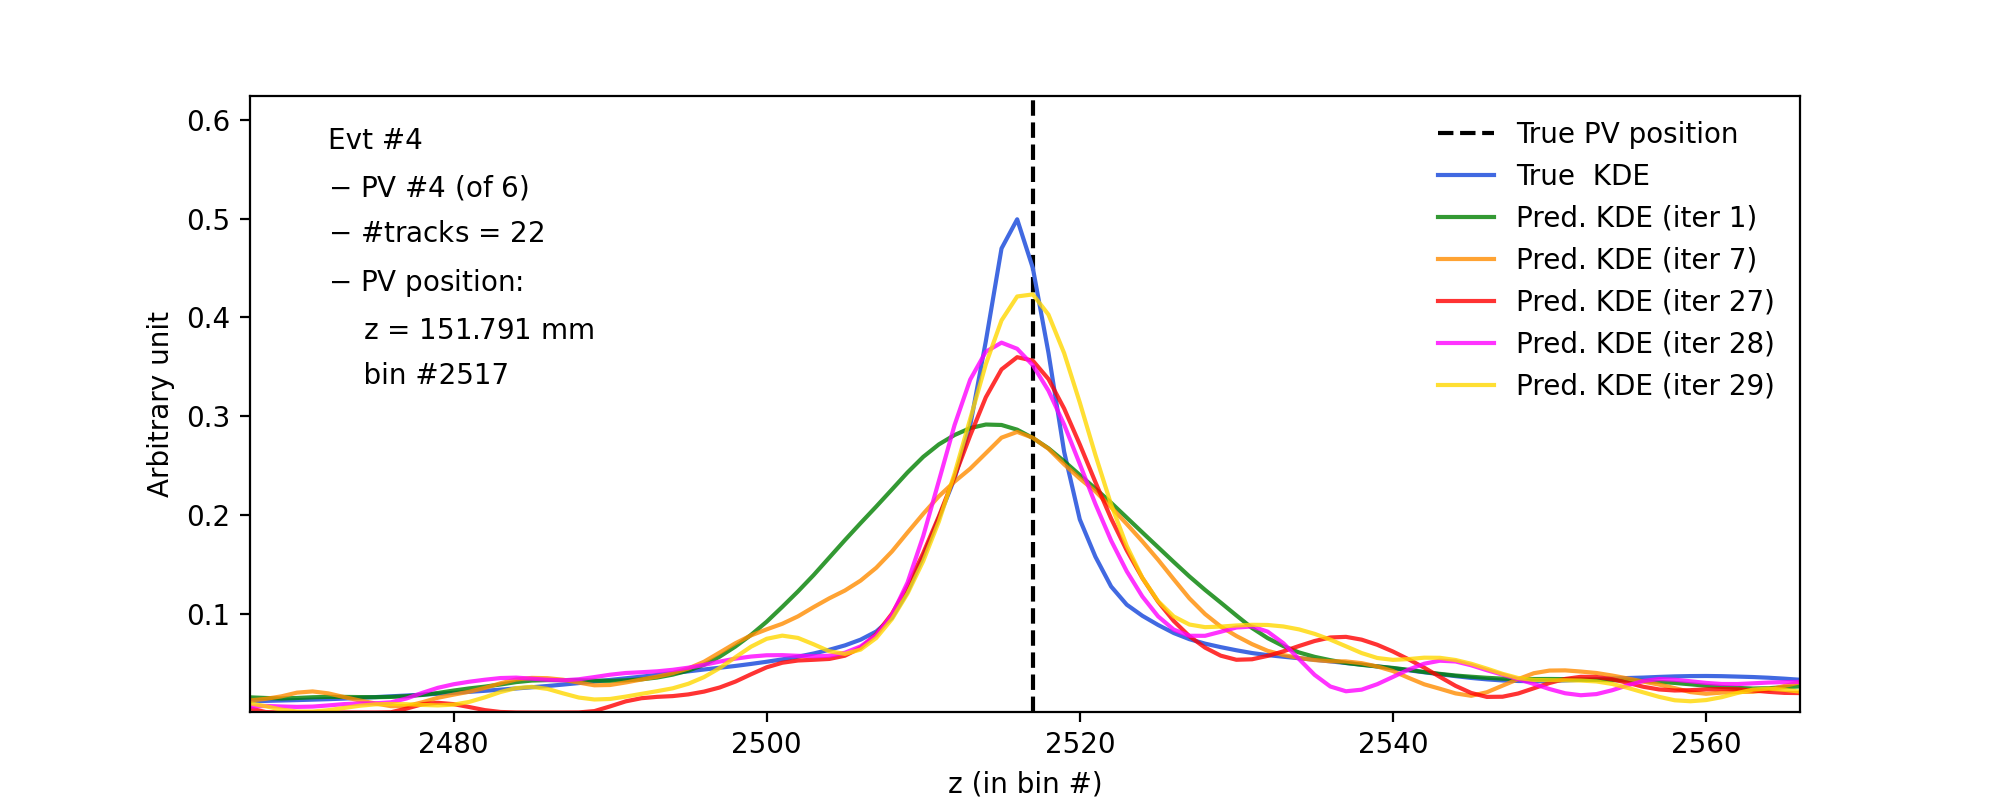

PV position and bin # =  (186.51968, 1, 24) 2865.0


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


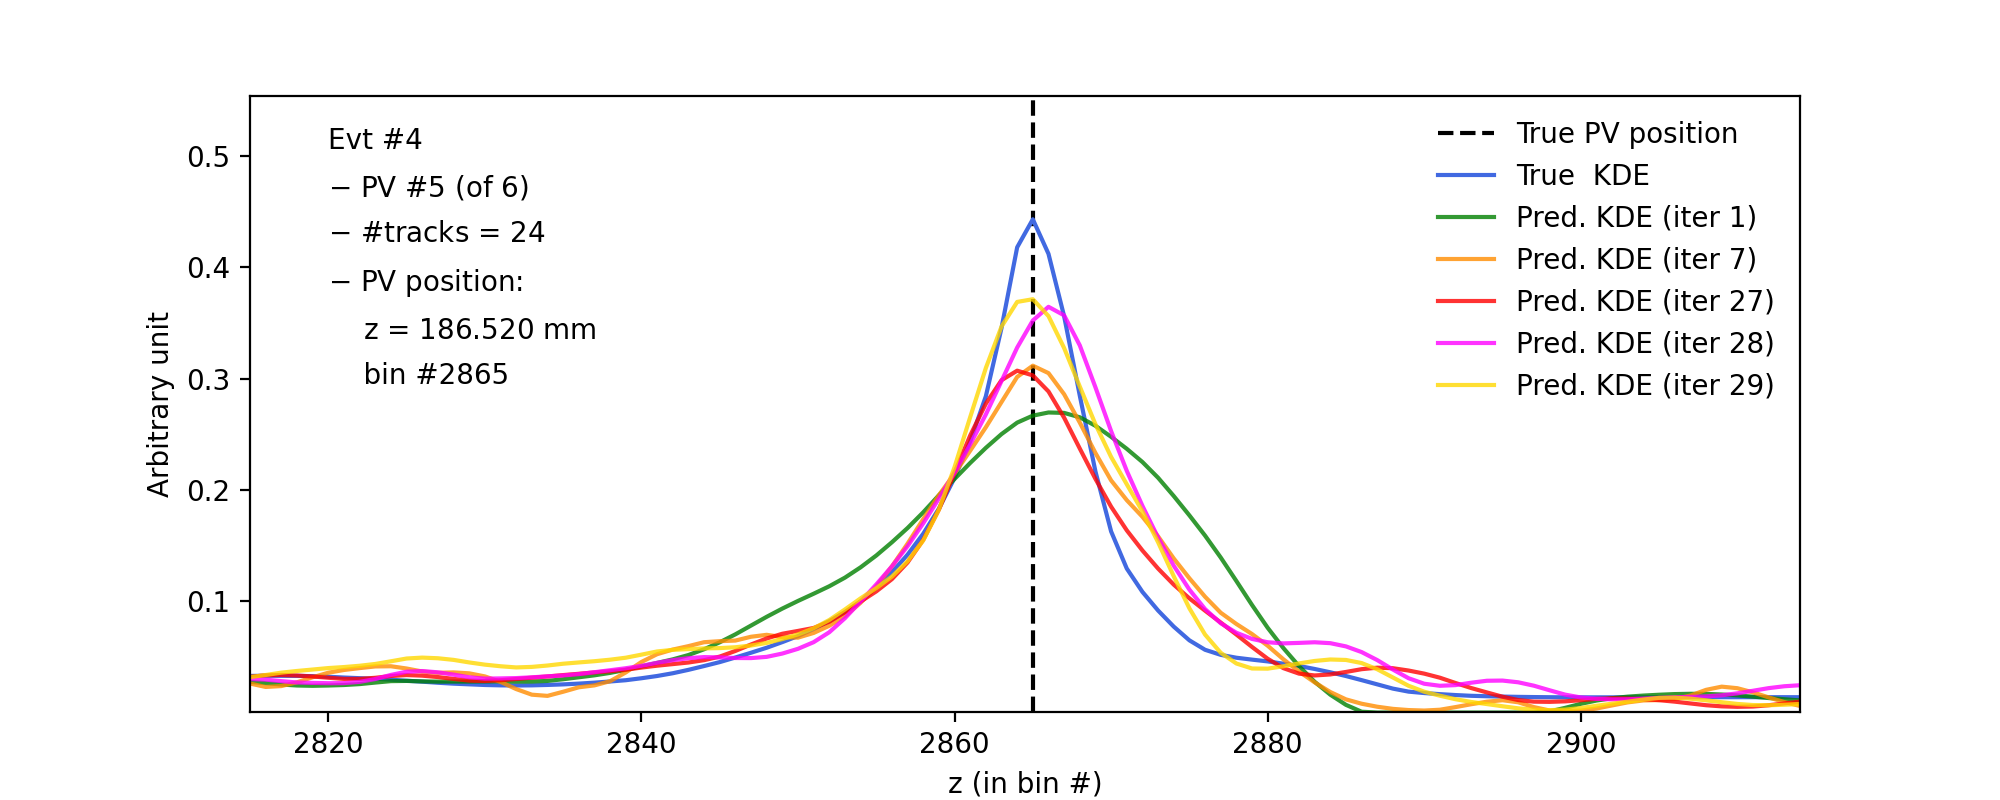

PV position and bin # =  (262.89627, 1, 23) 3628.0


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


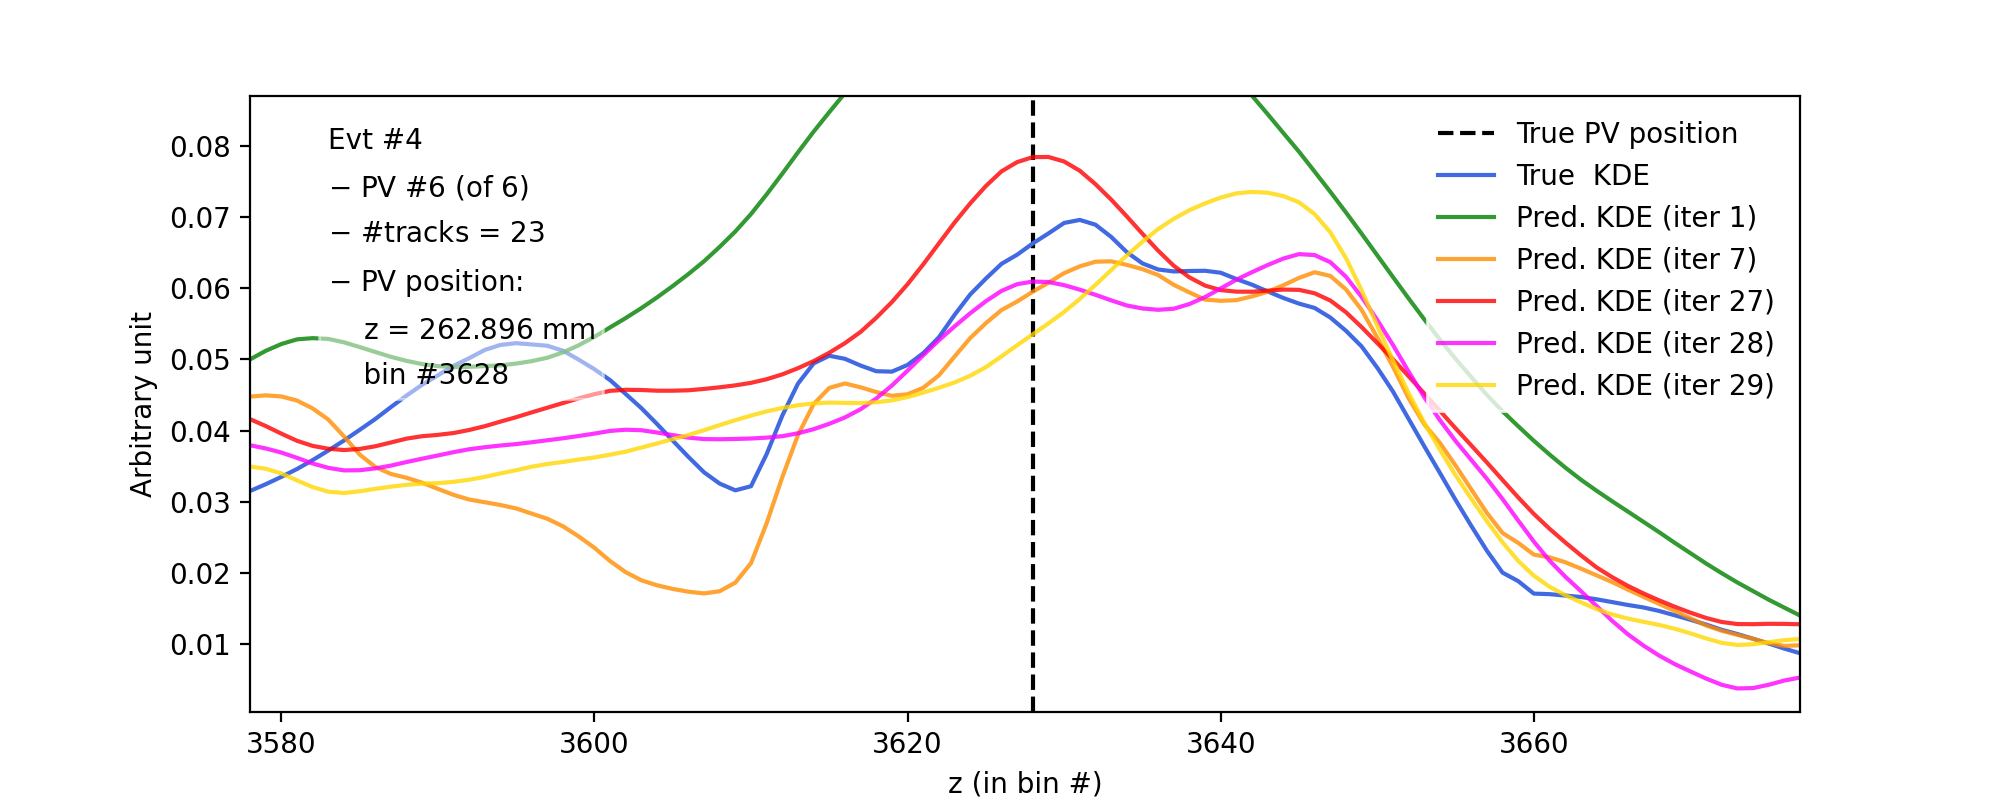

In [49]:
nFeatures = 4000
nTracks_good_PV = 5
maxEvt = 5
plt_name = ''
#for it in iters:
#    plt_name+='%s_'%(it)

with torch.no_grad():
    print("val_loader = ",val_loader)
    # Loop over the trained iterations to retrieve the predictions 
    for it in iters:
        outputs[it] = models[it](val_loader.dataset.tensors[0])

    # Get the number of events from the output of the first trained model 
    nEvts = outputs[iters[0]].shape[0]
    #nEvts = 5
    
    print("nEvts = ",nEvts)
    labels = val_loader.dataset.tensors[1]

    # Do something on the true distribution (KDEs) 
    y = labels.view(nEvts,-1,nFeatures)
    y = y.transpose(1,2)               
    #print("y.shape = ",y.shape)
    
    # ========================
    # ========================
    # --- LOOP over the events
    # ========================
    # ========================
    for iEvt in range(maxEvt):

        print("iEvt = ",iEvt)
        
        # --- Retrieve the TRUE KDEs
        y_kde = y[iEvt,:,0].cpu().numpy()
        # print("y_kde.shape = ",y_kde.shape)

        # --- Retrieve the PREDICTED KDEs for each trained model (iteration over same model)
        for it in iters:
            y_pred[it] = outputs[it][iEvt,:]
            y_pred[it] = y_pred[it].cpu().numpy()
        
        # --- Containers usefull for plotting
        pv_sorted = sorted(zip(PV.z[iEvt],PV.cat[iEvt],PV.n[iEvt]), key=lambda x: x[0])
        n_pvs = len(pv_sorted)
        good_pvs = []
        good_pv_bins = []
        pv_sorted_bins = []

        # --- LOOP over all PVs
        for ii in range(n_pvs):
                
            pv_sorted_bins.append(np.floor(10.*(pv_sorted[ii][0]+100)))
            
            # PV with at least 5 tracks are considered as good PVs
            # Can also filter using "pv_sorted[ii][1]", which is a boolean at 1 if nTracks_good_PV is >= 5
            if pv_sorted[ii][2]>=nTracks_good_PV:
                good_pvs.append(pv_sorted[ii])
                good_pv_bins.append(np.floor(10.*(pv_sorted[ii][0]+100)))

        n_good_pv_bins = len(good_pv_bins)
        
      
        # ==============================
        # --- Start plotting things here
        # ==============================
        fig, ax = plt.subplots()
        max_y_kde = max(y_kde)
        plt.ylim(0.0005,1.15*max_y_kde)

        pvstr = "PVs" # tag for the text box info on the plot
        if len(good_pv_bins)<=1:
            pvstr = "PV"
        
        # --- Add the true KDE distribution
        plt.plot(y_kde, color="royalblue", label="True KDE")

        # --- Add the predicted KDE distributions (for each model iteration)
        for it in iters:
            plt.plot(y_pred[it], color=mycolors[it], alpha = 0.8, label="Pred. KDE (iter %s)"%(it))
        
        # --- Add markers showing the PVs position
        # - LOOP over all PVs
        for ipv in range(n_pvs):
            xPV = pv_sorted_bins[ipv]
            yPV = max(y_kde[int(xPV)-50:int(xPV)+50]) + 0.05*max_y_kde
            plt.scatter((xPV),(yPV), s=61, c="navy", marker="s")
        # Add once more the last PV with the label for legend purpose (not ideal, but it works...)
        plt.scatter((xPV),(yPV), s=61, c="navy", marker="s", label='%s'%(pvstr))
        # - LOOP over good PVs
        for ipv in range(n_good_pv_bins):
            xPV = good_pv_bins[ipv]
            yPV = max(y_kde[int(xPV)-50:int(xPV)+50]) + 0.05*max_y_kde
            plt.scatter((xPV),(yPV), s=31, c="red", marker="o")
        # Add once more the last goo PV with the label for legend purpose (not ideal, but it works...)
        plt.scatter((xPV),(yPV), s=31, c="red", marker="o", label='%s (#Trks$\geq%s$)'%(pvstr,nTracks_good_PV))

        # --- Add the legend (in the upper-right corner: 'loc=1')
        plt.legend(loc=1, facecolor='white', edgecolor='white')

        # --- Text box info added on the top left part of the plot, with
        # - event number
        # - number of good PVs out of the total number of PVs for the event
        textstr = '\n'.join((
        r'Evt #%s' % (iEvt, ),     
        #r'$-$ %s good %s (of %s)' %(len(good_pv_bins),pvstr,len(pv_sorted)) 
        ))              
        props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes,verticalalignment='top', bbox=props,linespacing = 1.8)
        
        # --- Set the plot x- and y-axis labels
        ax.set_xlabel("z (in bin #)")
        ax.set_ylabel("Arbitrary unit")

        # --- Save the plot 
        fname = 'Evt%s'%(iEvt)
        plt.savefig(str(output_path / f'{fname}.png'))

        
        # =====================================================
        # =====================================================
        # --- Make the zoomed in plots for each of the good PV
        # =====================================================
        # =====================================================
        for jj in range(n_good_pv_bins):
            print("PV position and bin # = ", good_pvs[jj], good_pv_bins[jj])
            
            nLow =  int(good_pv_bins[jj]-50)
            nHigh = int(good_pv_bins[jj]+50)
            x=[i+nLow for i in range(100)]

            fig, ax = plt.subplots()
            plt.xlim(x[0],x[99])
            plt.ylim(0.0005,1.25*max(y_kde[nLow:nHigh]))

            # --- Add vertical line showing the good PV position
            plt.axvline(x=good_pv_bins[jj], color='black', linestyle='dashed', label="True PV position")

            # --- Add the true KDE distribution
            plt.plot(x,y_kde[nLow:nHigh], color="royalblue", label="True  KDE")

            # --- Add the predicted KDE distributions (for each model iteration)
            for it in iters:
                plt.plot(x,y_pred[it][nLow:nHigh], color=mycolors[it], alpha = 0.8, label="Pred. KDE (iter %s)"%(it))

            # --- Add the legend (in the upper-right corner: 'loc=1')
            plt.legend(loc=1, facecolor='white', edgecolor='white')

            # --- Text box info added on the top left part of the plot, with
            # - PV number
            # - number of tracks origiating from the PV
            # - PV position (in z and bin number)
            textstr = '\n'.join((
            r'Evt #%s' % (iEvt, ),     
            r'$-$ PV #%s (of %s)' %(jj+1,n_good_pv_bins ),
            r'$-$ #tracks = %s' % (good_pvs[jj][2], ),     
            r'$-$ PV position:',              
            r'    z = $%.3f$ mm' % (good_pvs[jj][0]),             
            r'    bin #%.0f' % (good_pv_bins[jj])))              
            #r'PV_bin = %.0f' % (good_pv_bins[jj], )))            
            props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0.5) #
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes,verticalalignment='top', bbox=props,linespacing = 1.8)#, fontsize=14
            ax.set_xlabel("z (in bin #)")
            ax.set_ylabel("Arbitrary unit")
            fname = 'Evt%s_goodPV%s'%(iEvt,jj)
            plt.savefig(str(output_path / f'{fname}.png'))
